In [0]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch

# Data

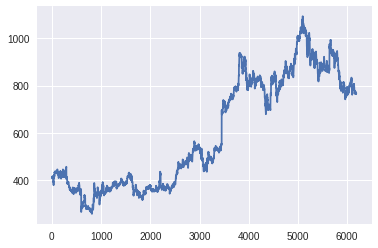

In [0]:
import pandas as pd

df = pd.read_csv('SUNTV.csv')
data = df['Close'].values
plt.plot(data)
plt.show()

In [0]:
len(data)

6186

In [0]:
torch.manual_seed(2)
import torch.nn as nn


class ConvSeq(nn.Module):
    def __init__(self):
        super(ConvSeq, self).__init__()
        self.conv1d_1 = nn.Conv1d(1,20,5)
        self.Pool1d_1 = nn.MaxPool1d(2, stride=2)
        self.conv1d_2 = nn.Conv1d(20,40,5)
        self.Pool1d_2 = nn.MaxPool1d(2, stride=2)
        self.conv1d_3 = nn.Conv1d(40,80,5)
        self.relu = nn.ReLU()
        self.gru = nn.GRU(1440,512,3, batch_first=True)
        self.fcc = nn.Linear(512,100)
        
    
    def forward(self, x, hidden):
        """
        100 data -Conv1d-> 80 feat -MaxPool1d-> 40 feat 
        -Conv1d-> 20 feat -MaxPool1d-> 10 feat 
        -Conv1d-> 5 feat
        """
        # Conv feature extractor start
        x = self.conv1d_1(x)
        x = self.Pool1d_1(x)
        x = self.relu(x)
        x = self.conv1d_2(x)
        x = self.Pool1d_2(x)
        x = self.relu(x)
        x = self.conv1d_3(x)
        # Conv feature extractor end
        x = x.view(x.size(0), 1,  -1)
#         print(x.shape)
        
         # RNN starts
        output, hn = self.gru(x, hidden)
#         print(output.shape)
         # RNN ends
        
         # fcc starts
        y = self.fcc(output)
#         y = self.relu(y)
         # fcc ends
        return y, hn


In [0]:
torch.manual_seed(2)

class ConvSeq2(nn.Module):
    def __init__(self):
        super(ConvSeq2, self).__init__()
        self.conv1d_1 = nn.Conv1d(1,20,5)
        self.Pool1d_1 = nn.MaxPool1d(2, stride=1)
        self.conv1d_2 = nn.Conv1d(20,40,5)
        self.Pool1d_2 = nn.MaxPool1d(2, stride=1)
        self.conv1d_3 = nn.Conv1d(40,80,5)
        self.relu = nn.ReLU()
        self.gru = nn.GRU(400,256,3, batch_first=True)
        self.fcc = nn.Linear(256,20)
        
    
    def forward(self, x, hidden):
        """
        100 data -Conv1d-> 80 feat -MaxPool1d-> 40 feat 
        -Conv1d-> 20 feat -MaxPool1d-> 10 feat 
        -Conv1d-> 5 feat
        """
        # Conv feature extractor start
        x = self.conv1d_1(x)
        x = self.Pool1d_1(x)
        x = self.relu(x)

        x = self.conv1d_2(x)
        x = self.Pool1d_2(x)
        x = self.relu(x)

#         x = self.conv1d_3(x)
        # Conv feature extractor end
        x = x.view(x.size(0), 1,  -1)
#         print(x.shape)
        
         # RNN starts
        output, hn = self.gru(x, hidden)
#         print(output.shape)
         # RNN ends
        
         # fcc starts
        y = self.fcc(output)
#         y = self.relu(y)
         # fcc ends
        return y, hn


In [0]:
# d = torch.tensor(d)
d = torch.rand(20,1,20)
# h = torch.rand(2,1,50)
h = None
d.shape

torch.Size([20, 1, 20])

In [0]:
model = ConvSeq2()
model(d, h)[0].shape

torch.Size([20, 1, 20])

In [0]:
print(model)

ConvSeq(
  (conv1d_1): Conv1d(1, 20, kernel_size=(5,), stride=(1,))
  (Pool1d_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1d_2): Conv1d(20, 40, kernel_size=(5,), stride=(1,))
  (Pool1d_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1d_3): Conv1d(40, 80, kernel_size=(5,), stride=(1,))
  (relu): ReLU()
  (gru): GRU(1440, 512, num_layers=3, batch_first=True)
  (fcc): Linear(in_features=512, out_features=100, bias=True)
)


In [0]:
#

In [0]:
seq_length = 101

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# test that dimensions are as expected
test_rnn = ConvSeq()

# generate evenly spaced, test data pts
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((1, seq_length))

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 1, 101])
Output size:  torch.Size([1, 100])
Hidden state size:  torch.Size([2, 1, 50])


In [0]:
# instantiate an RNN
rnn =  ConvSeq2()
print(rnn)

ConvSeq2(
  (conv1d_1): Conv1d(1, 20, kernel_size=(5,), stride=(1,))
  (Pool1d_1): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv1d_2): Conv1d(20, 40, kernel_size=(5,), stride=(1,))
  (Pool1d_2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv1d_3): Conv1d(40, 80, kernel_size=(5,), stride=(1,))
  (relu): ReLU()
  (gru): GRU(400, 256, num_layers=3, batch_first=True)
  (fcc): Linear(in_features=256, out_features=20, bias=True)
)


In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.1)
rnn.cuda()

ConvSeq2(
  (conv1d_1): Conv1d(1, 20, kernel_size=(5,), stride=(1,))
  (Pool1d_1): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv1d_2): Conv1d(20, 40, kernel_size=(5,), stride=(1,))
  (Pool1d_2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv1d_3): Conv1d(40, 80, kernel_size=(5,), stride=(1,))
  (relu): ReLU()
  (gru): GRU(400, 256, num_layers=3, batch_first=True)
  (fcc): Linear(in_features=256, out_features=20, bias=True)
)

In [0]:
data = data.reshape(-1, 1)

In [0]:
from sklearn import preprocessing


min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(data)
data = min_max_scaler.transform(data)

data[:10]

array([[0.18402965],
       [0.18749626],
       [0.18289403],
       [0.1829538 ],
       [0.18265495],
       [0.1829538 ],
       [0.18145957],
       [0.18952842],
       [0.18952842],
       [0.1876158 ]])

In [0]:
min_max_scaler.inverse_transform(data)

array([[411.15],
       [414.05],
       [410.2 ],
       ...,
       [765.85],
       [767.8 ],
       [768.05]])

In [0]:
data = data[:int(len(data)*0.8)]
data_test = data[int(len(data)*0.8):]

In [0]:
len(data)

6186

In [0]:

# train the RNN
def train(rnn, n_steps, hidden = None):
    print('entered train func() !!')      
    
    for batch_i, step in enumerate(range(n_steps)):
        loss_it = 0 
        for i in range(int(len(data)-100)):
            x = data[i :  i+100].reshape((1,100)) 
            y = data[i+1 :  i+101].reshape(1,100)
            x_tensor = torch.Tensor(x).unsqueeze(0).cuda()
            y_tensor = torch.Tensor(y).cuda()
           
            prediction, hidden = rnn(x_tensor, hidden)
            hidden = hidden.data

            loss = criterion(prediction.squeeze(0), y_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_it += loss.item()

        print('Epoch: ', step+1)
        print('Loss: ', loss_it/int(len(data)/100))
        plt.plot( x.reshape(100,1), 'r.') # input
        plt.plot(prediction.data.cpu().numpy().flatten(), 'b.')# predictions
        plt.show()
    
    return rnn, hidden

In [0]:

# train the RNN
def train2(rnn, n_steps, hidden = None):
    print('entered train func() !!')      
    
    for batch_i, step in enumerate(range(n_steps)):
        loss_it = 0 
        for i in range(int(len(data)-20)):
            x = data[i :  i+20].reshape((1,20)) 
            y = data[i+1 :  i+21].reshape(1,20)
            x_tensor = torch.Tensor(x).unsqueeze(0).cuda()
            y_tensor = torch.Tensor(y).cuda()
            
            prediction, hidden = rnn(x_tensor, hidden)
            hidden = hidden.data

            loss = criterion(prediction.squeeze(0), y_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_it += loss.item()

        print('Epoch: ', step+1)
        print('Loss: ', loss_it/int(len(data)-20))
        plt.plot( x.reshape(20,1), 'r.') # input
        plt.plot(prediction.data.cpu().numpy().flatten(), 'b.')# predictions
        plt.show()
    
    return rnn, hidden

entered train func() !!
Epoch:  1
Loss:  0.0007699977915542716


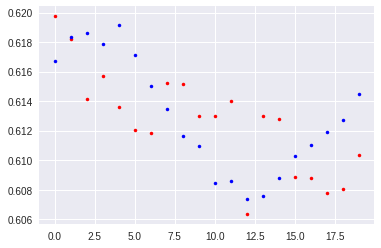

Epoch:  2
Loss:  0.0007629206955340626


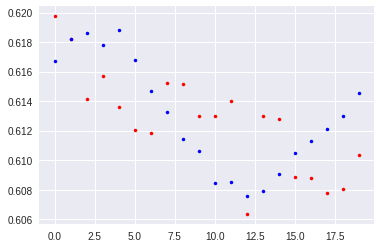

Epoch:  3
Loss:  0.0007613354875735905


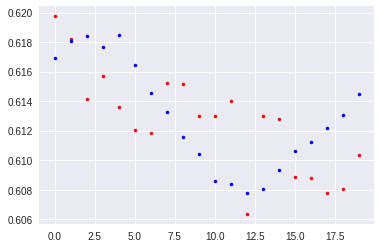

Epoch:  4
Loss:  0.0007626022766608058


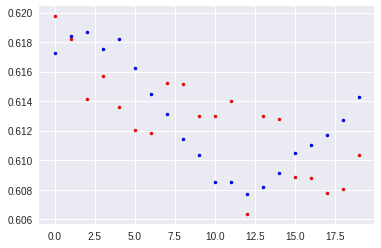

Epoch:  5
Loss:  0.0007617254516748377


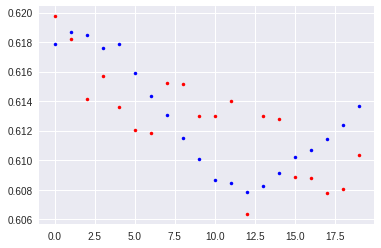

Epoch:  6
Loss:  0.0007551777105381571


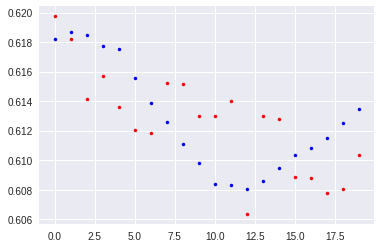

Epoch:  7
Loss:  0.0007458949932850316


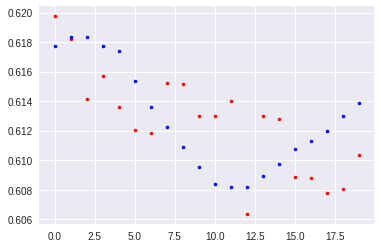

Epoch:  8
Loss:  0.0007420687438193394


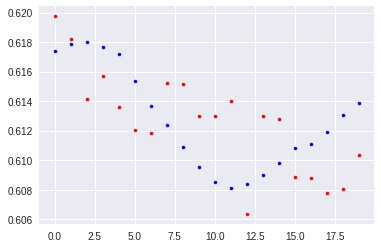

Epoch:  9
Loss:  0.0007350276270210503


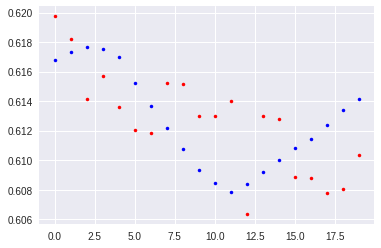

Epoch:  10
Loss:  0.000734432424355494


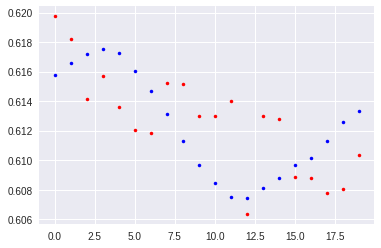

In [0]:
n_steps = 10
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.1, momentum=0.9)
rnn1, hidden =  train2(rnn1, n_steps, hidden)

entered train func() !!
Epoch:  1
Loss:  7.516993056636624e-05


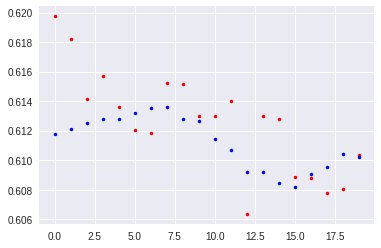

Epoch:  2
Loss:  7.498483531577532e-05


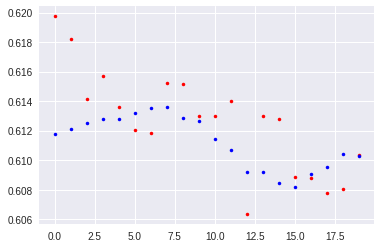

Epoch:  3
Loss:  7.477238405148761e-05


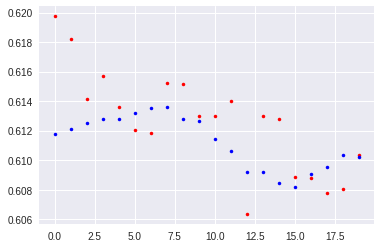

Epoch:  4
Loss:  7.456028415954807e-05


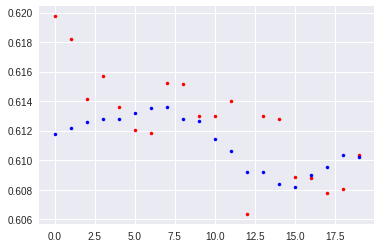

Epoch:  5
Loss:  7.430502466551715e-05


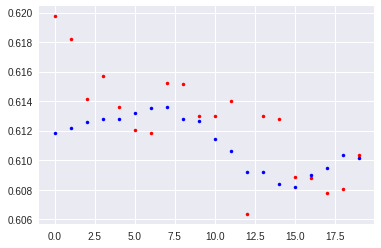

Epoch:  6
Loss:  7.406119558630782e-05


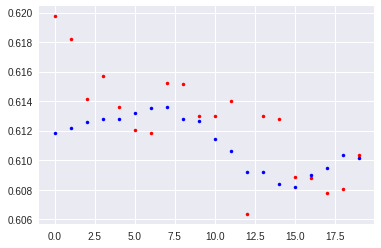

Epoch:  7
Loss:  7.380197371148933e-05


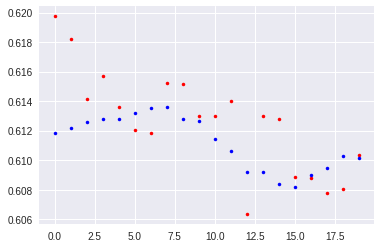

Epoch:  8
Loss:  7.352387542320434e-05


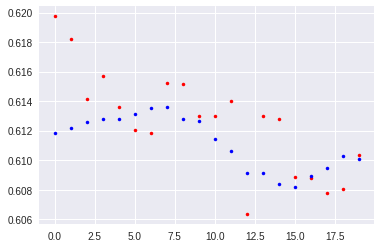

Epoch:  9
Loss:  7.325945025502216e-05


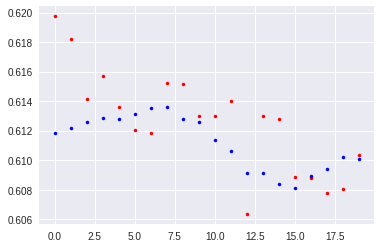

Epoch:  10
Loss:  7.29578280458725e-05


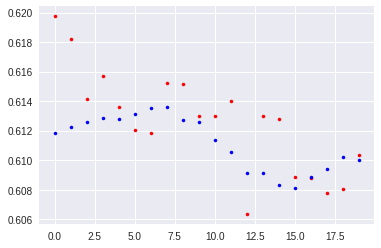

Epoch:  11
Loss:  7.269775438424096e-05


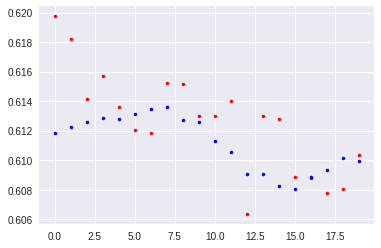

Epoch:  12
Loss:  7.242293342321996e-05


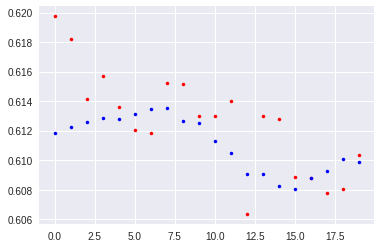

Epoch:  13
Loss:  7.220182236867799e-05


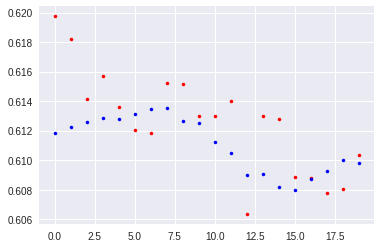

Epoch:  14
Loss:  7.196510589358908e-05


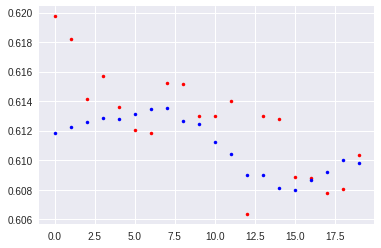

Epoch:  15
Loss:  7.170068448848549e-05


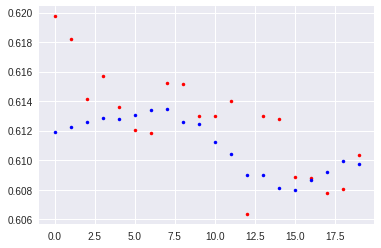

Epoch:  16
Loss:  7.148415680909567e-05


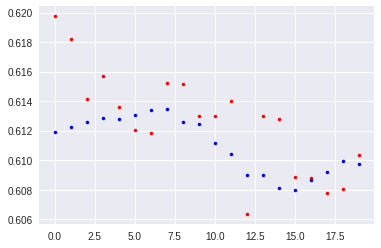

Epoch:  17
Loss:  7.127296070262512e-05


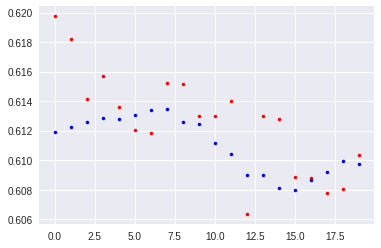

Epoch:  18
Loss:  7.103147764488349e-05


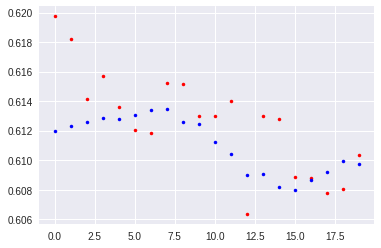

Epoch:  19
Loss:  7.083240980830902e-05


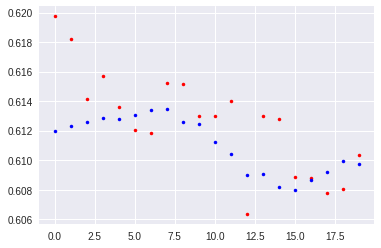

Epoch:  20
Loss:  7.061149591945213e-05


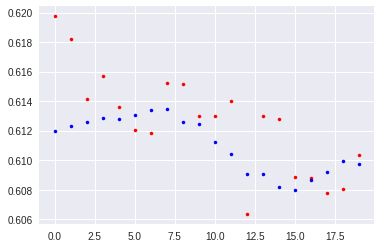

Epoch:  21
Loss:  7.04049314271405e-05


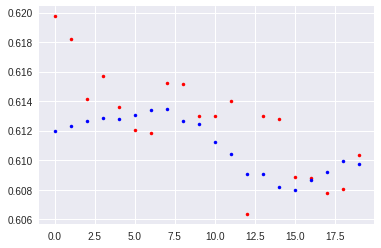

Epoch:  22
Loss:  7.019531830650506e-05


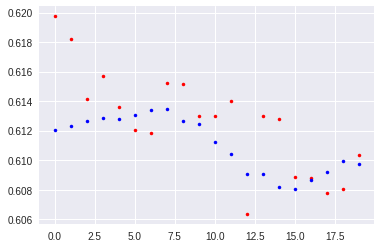

Epoch:  23
Loss:  6.997749050703878e-05


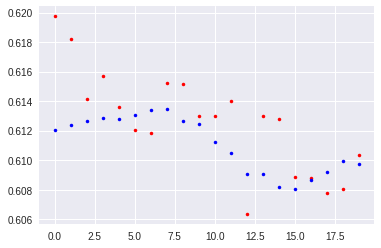

Epoch:  24
Loss:  6.975710538753801e-05


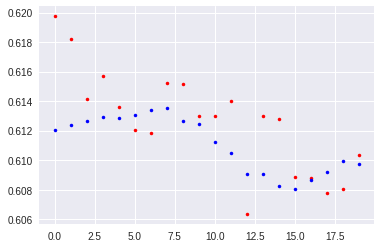

Epoch:  25
Loss:  6.958002364020726e-05


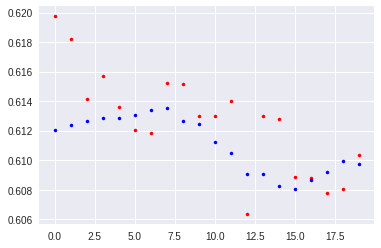

Epoch:  26
Loss:  6.937725174445269e-05


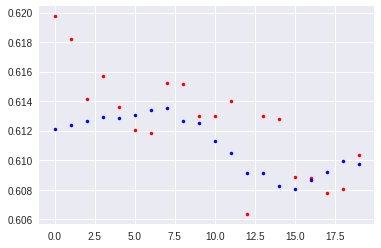

Epoch:  27
Loss:  6.912510940447341e-05


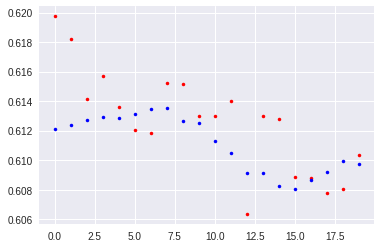

Epoch:  28
Loss:  6.884336662415434e-05


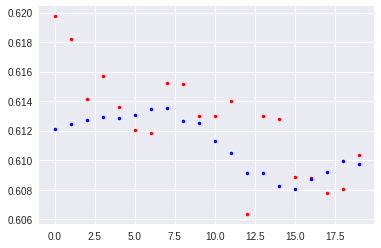

Epoch:  29
Loss:  6.853859908647468e-05


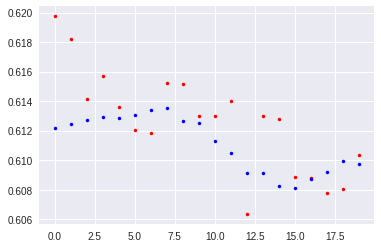

Epoch:  30
Loss:  6.834275393315975e-05


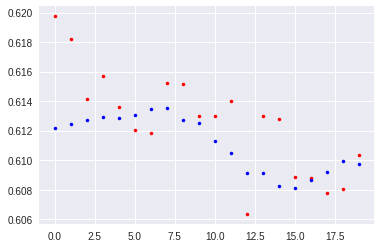

Epoch:  31
Loss:  6.814470323057871e-05


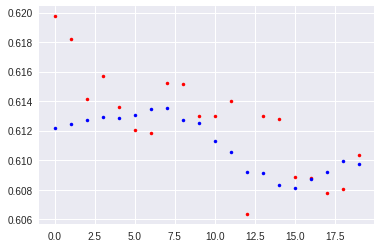

Epoch:  32
Loss:  6.787482103996062e-05


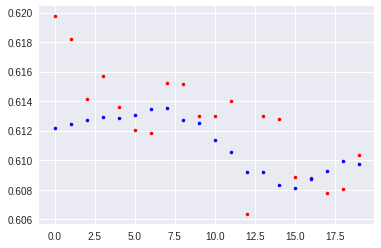

Epoch:  33
Loss:  6.75764466698923e-05


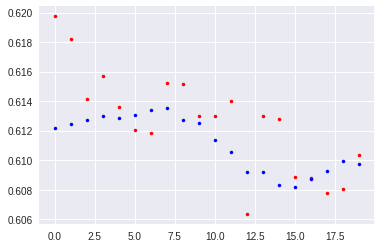

Epoch:  34
Loss:  6.728601295921086e-05


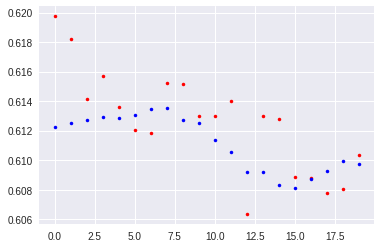

Epoch:  35
Loss:  6.704661011274834e-05


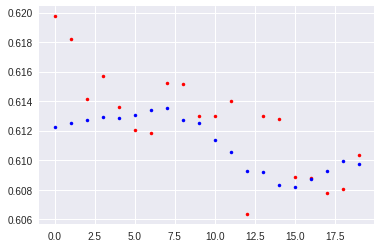

Epoch:  36
Loss:  6.682034310845957e-05


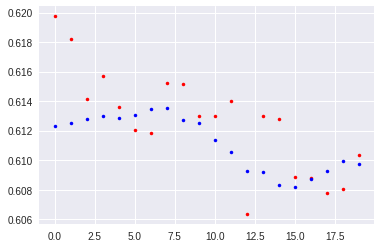

Epoch:  37
Loss:  6.652168391353515e-05


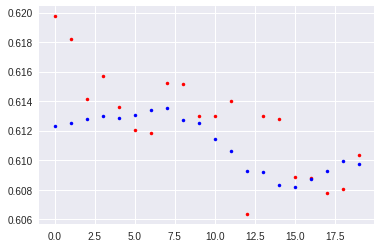

Epoch:  38
Loss:  6.614034179940073e-05


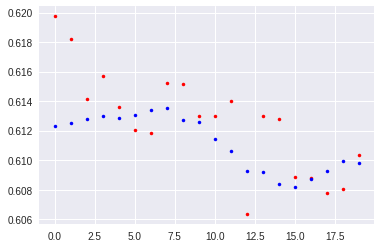

Epoch:  39
Loss:  6.578405758178421e-05


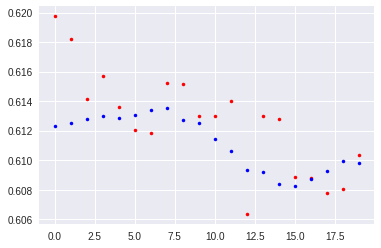

Epoch:  40
Loss:  6.54818212719035e-05


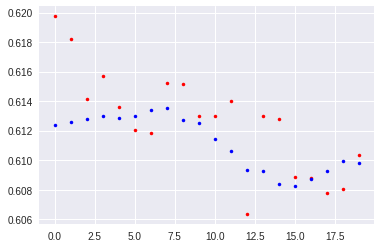

Epoch:  41
Loss:  6.51399515846139e-05


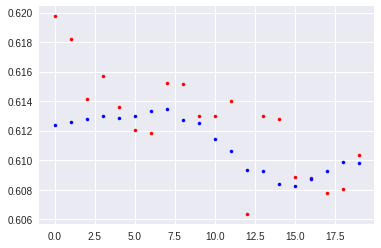

Epoch:  42
Loss:  6.503280423980732e-05


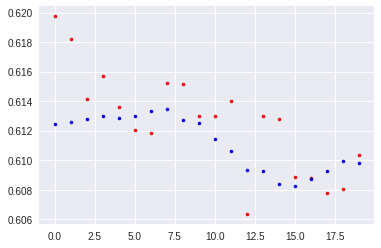

Epoch:  43
Loss:  6.485148207601689e-05


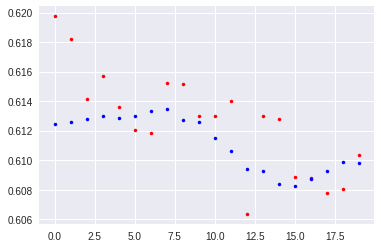

Epoch:  44
Loss:  6.471185270190198e-05


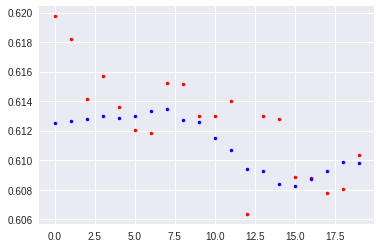

Epoch:  45
Loss:  6.455352064768443e-05


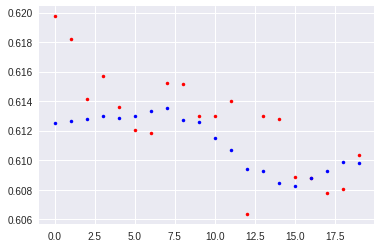

Epoch:  46
Loss:  6.439602685879227e-05


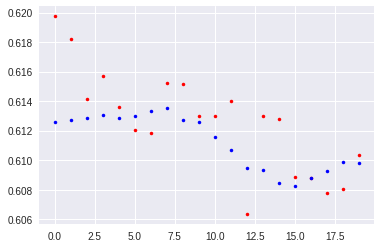

Epoch:  47
Loss:  6.427182740497598e-05


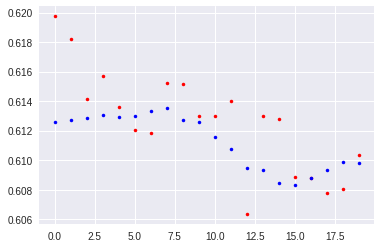

Epoch:  48
Loss:  6.407708176248071e-05


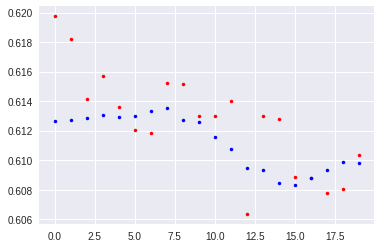

Epoch:  49
Loss:  6.392899965696685e-05


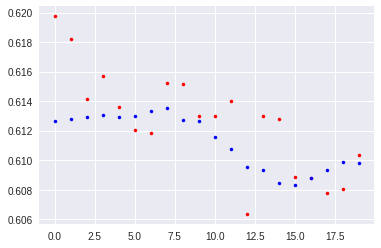

Epoch:  50
Loss:  6.373034650970846e-05


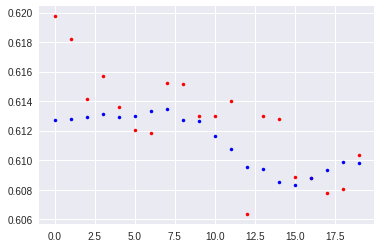

In [0]:
n_steps = 50
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.01, momentum=0.9)
rnn1, hidden =  train2(rnn1, n_steps, hidden)

entered train func() !!
Epoch:  1
Loss:  6.347890306880137e-05


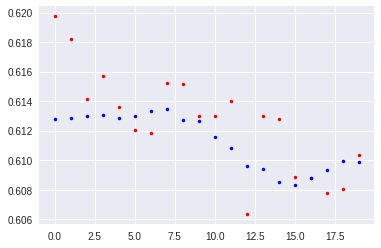

Epoch:  2
Loss:  6.33901076827659e-05


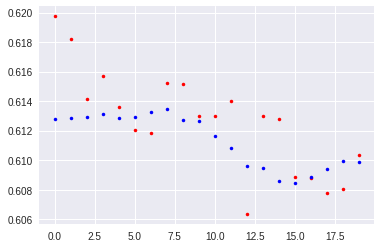

Epoch:  3
Loss:  6.331633809653257e-05


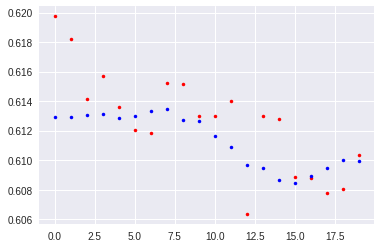

Epoch:  4
Loss:  6.314972493902686e-05


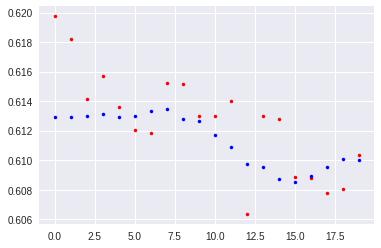

Epoch:  5
Loss:  6.30291801862526e-05


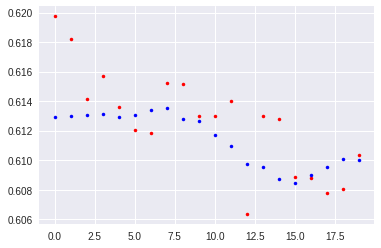

Epoch:  6
Loss:  6.287035375729864e-05


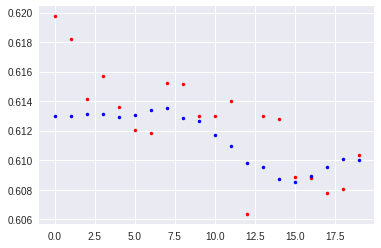

Epoch:  7
Loss:  6.2741543449543e-05


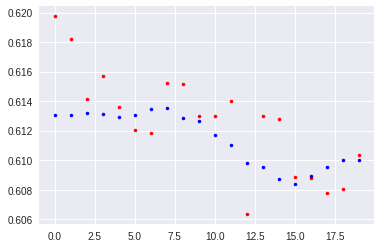

Epoch:  8
Loss:  6.257526139711614e-05


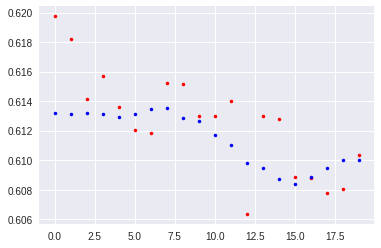

Epoch:  9
Loss:  6.247365761662894e-05


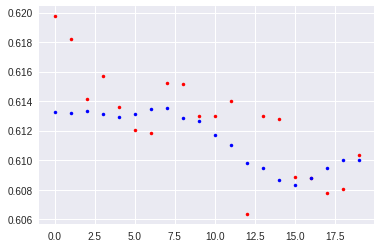

Epoch:  10
Loss:  6.229762906703912e-05


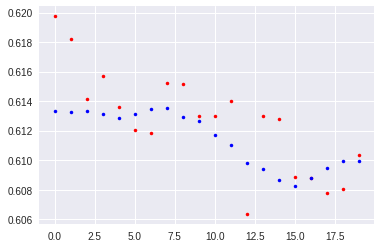

Epoch:  11
Loss:  6.216150944114625e-05


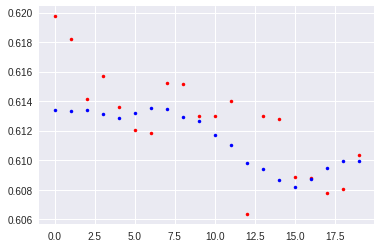

Epoch:  12
Loss:  6.197690877380365e-05


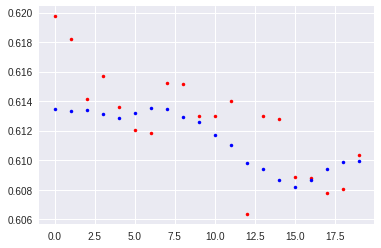

Epoch:  13
Loss:  6.182640277544986e-05


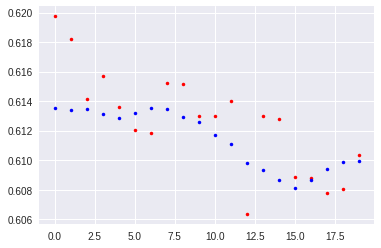

Epoch:  14
Loss:  6.161039055529824e-05


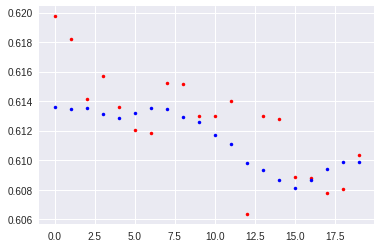

Epoch:  15
Loss:  6.145458395712464e-05


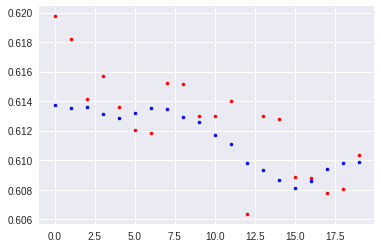

Epoch:  16
Loss:  6.122020827265512e-05


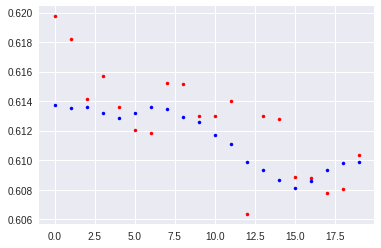

Epoch:  17
Loss:  6.109606460378639e-05


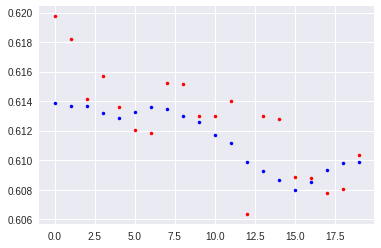

Epoch:  18
Loss:  6.083839872131445e-05


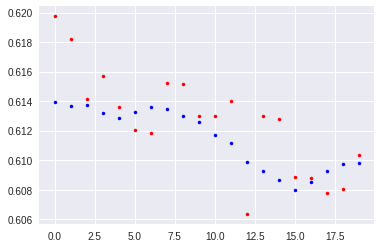

Epoch:  19
Loss:  6.0658296148839915e-05


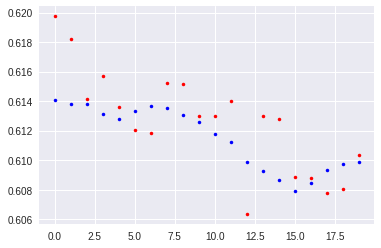

Epoch:  20
Loss:  6.0374986700231674e-05


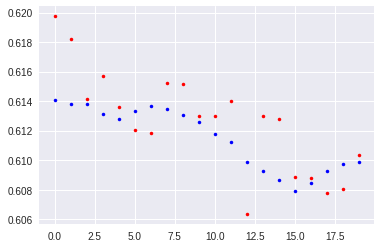

Epoch:  21
Loss:  6.013660319510519e-05


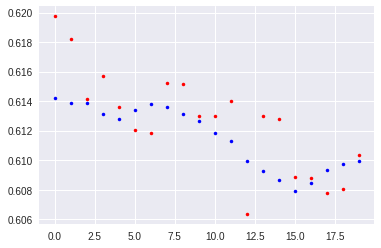

Epoch:  22
Loss:  5.990367115112591e-05


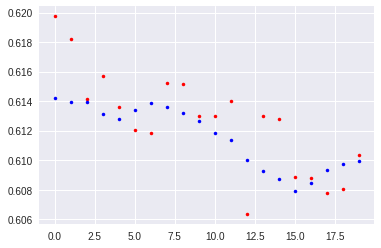

Epoch:  23
Loss:  5.960538764571435e-05


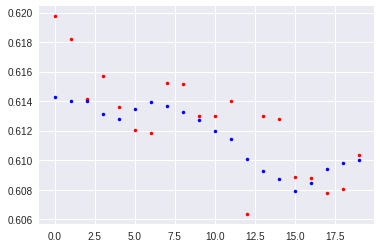

Epoch:  24
Loss:  5.915391858736063e-05


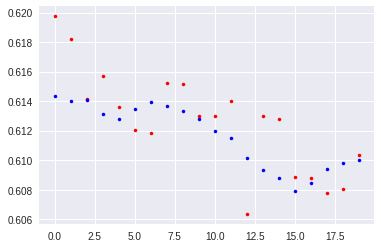

Epoch:  25
Loss:  5.8634681629095474e-05


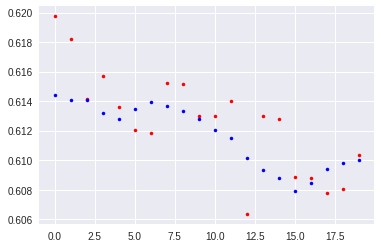

Epoch:  26
Loss:  5.81287103240316e-05


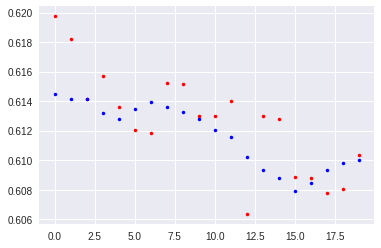

Epoch:  27
Loss:  5.754167547841636e-05


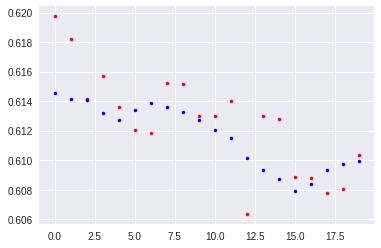

Epoch:  28
Loss:  5.6802607263601115e-05


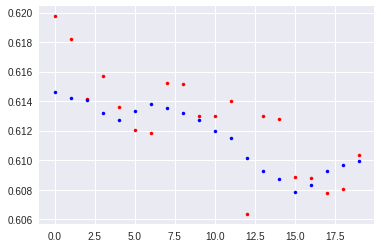

Epoch:  29
Loss:  5.647844929799464e-05


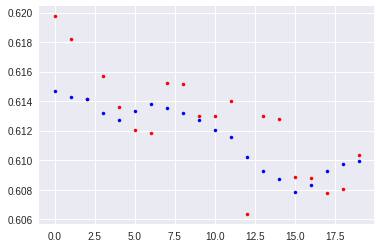

Epoch:  30
Loss:  5.633926685034688e-05


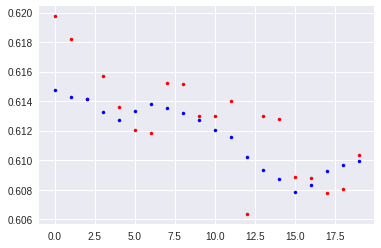

Epoch:  31
Loss:  5.6145419030514184e-05


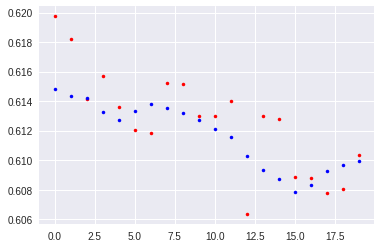

Epoch:  32
Loss:  5.5989405549934044e-05


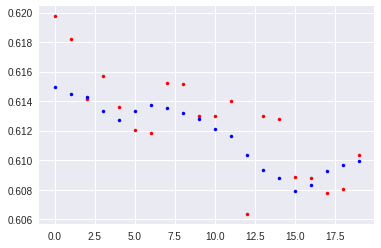

Epoch:  33
Loss:  5.5883018420105895e-05


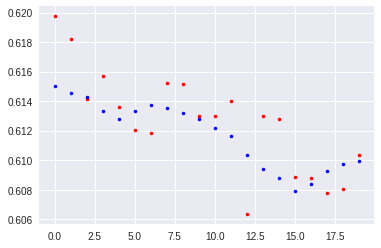

Epoch:  34
Loss:  5.577012152766923e-05


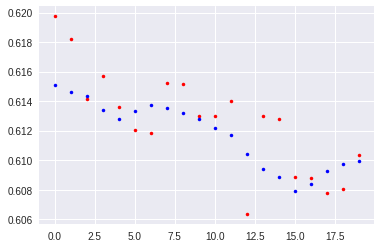

Epoch:  35
Loss:  5.565063260478304e-05


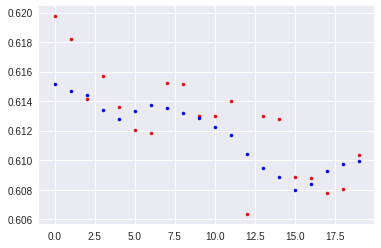

Epoch:  36
Loss:  5.554178667935234e-05


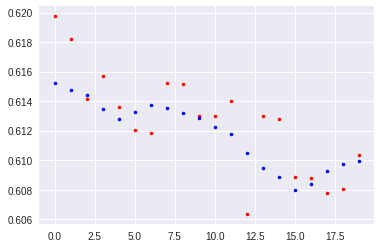

Epoch:  37
Loss:  5.541609255905212e-05


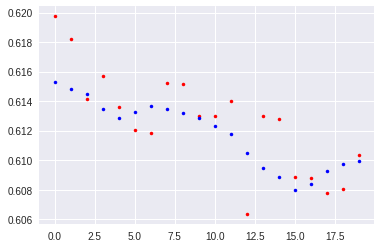

Epoch:  38
Loss:  5.5312299068782903e-05


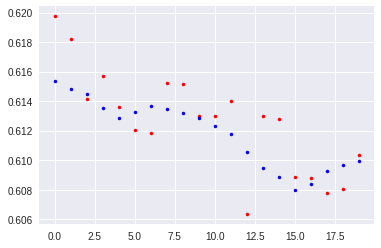

Epoch:  39
Loss:  5.521269191124441e-05


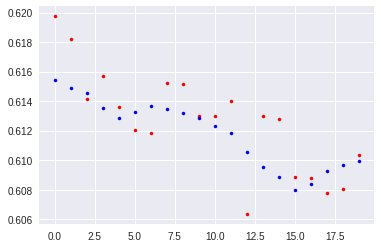

Epoch:  40
Loss:  5.510617070239383e-05


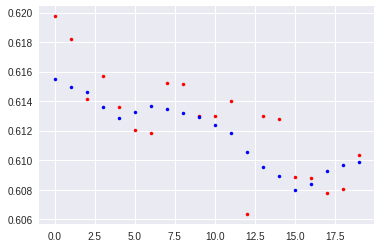

Epoch:  41
Loss:  5.500132184778839e-05


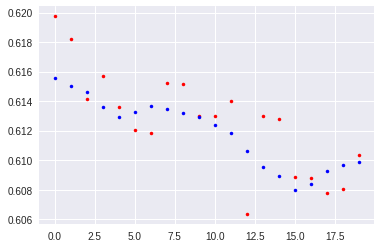

Epoch:  42
Loss:  5.4835645655188886e-05


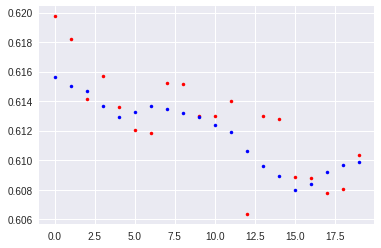

Epoch:  43
Loss:  5.471454727502396e-05


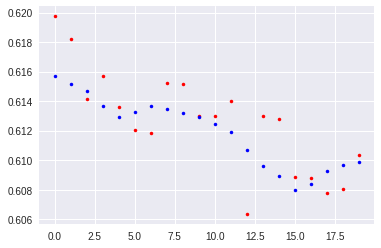

Epoch:  44
Loss:  5.462584164703315e-05


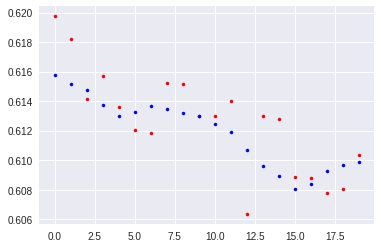

Epoch:  45
Loss:  5.440198312184505e-05


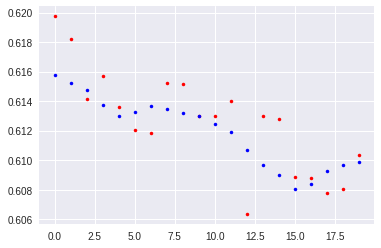

Epoch:  46
Loss:  5.428051906152262e-05


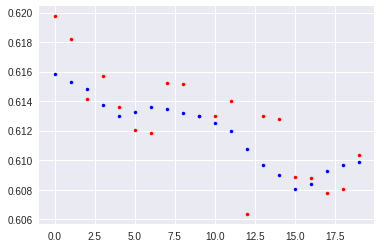

Epoch:  47
Loss:  5.417011551358565e-05


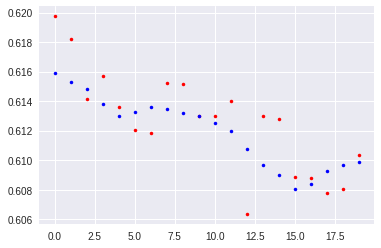

Epoch:  48
Loss:  5.398900922472738e-05


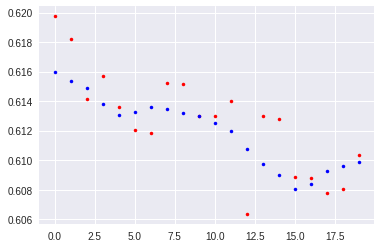

Epoch:  49
Loss:  5.3890196675367325e-05


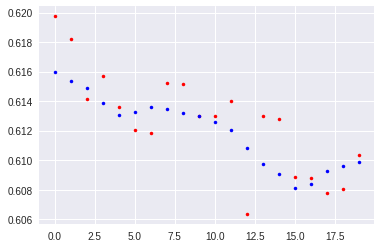

Epoch:  50
Loss:  5.375390773423444e-05


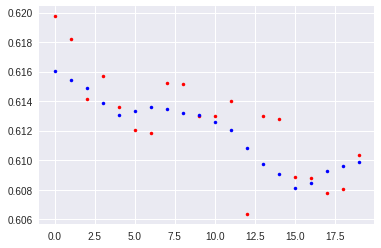

In [0]:
n_steps = 50
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.01, momentum=0.9)
rnn1, hidden =  train2(rnn1, n_steps, hidden)

entered train func() !!
Epoch:  1
Loss:  0.00010582198431632876


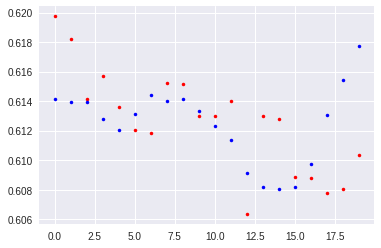

Epoch:  2
Loss:  8.602001506704847e-05


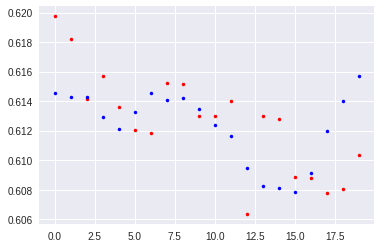

Epoch:  3
Loss:  7.832327085268479e-05


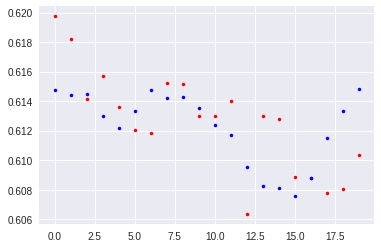

Epoch:  4
Loss:  7.217789994666589e-05


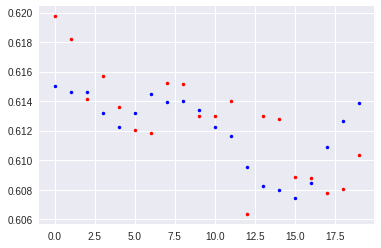

Epoch:  5
Loss:  6.757542511389389e-05


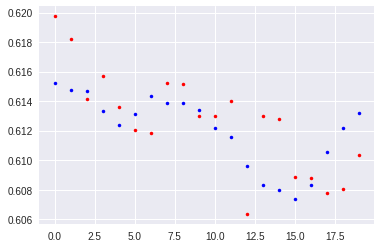

Epoch:  6
Loss:  6.407301248267502e-05


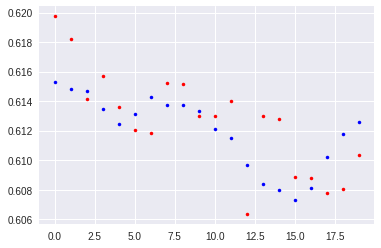

Epoch:  7
Loss:  6.130425069305126e-05


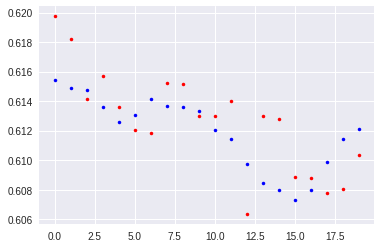

Epoch:  8
Loss:  5.905537444816252e-05


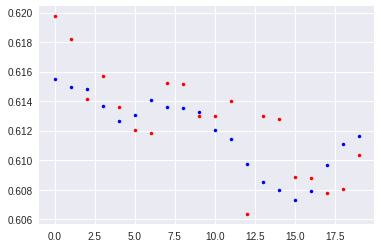

Epoch:  9
Loss:  5.720923036276847e-05


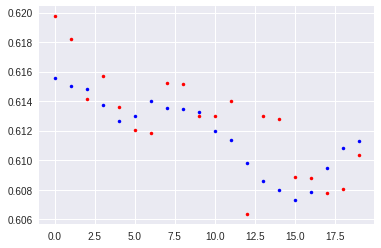

Epoch:  10
Loss:  5.566389784523805e-05


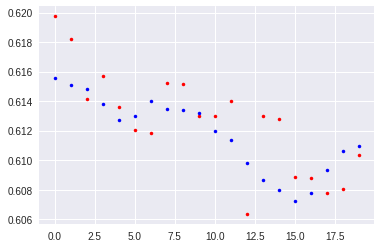

Epoch:  11
Loss:  5.4385144201690094e-05


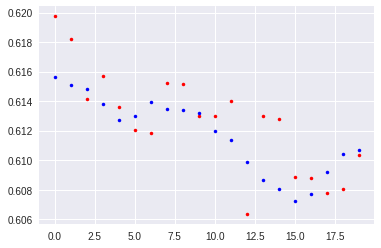

Epoch:  12
Loss:  5.334169242103202e-05


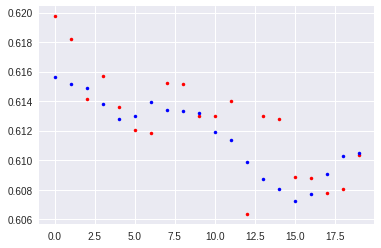

Epoch:  13
Loss:  5.247254749835062e-05


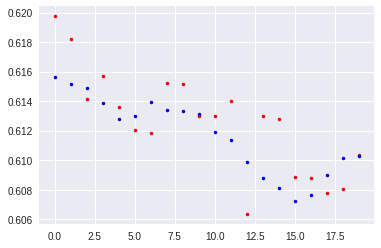

Epoch:  14
Loss:  5.173005637105682e-05


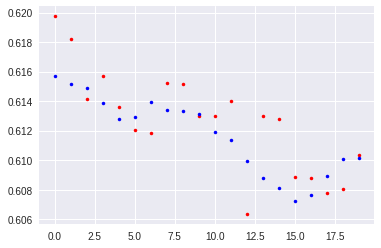

Epoch:  15
Loss:  5.108337526090316e-05


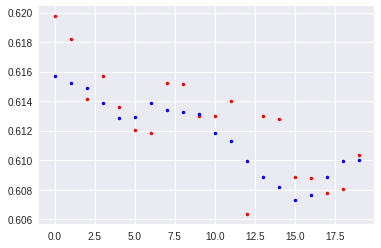

Epoch:  16
Loss:  5.0509318252835896e-05


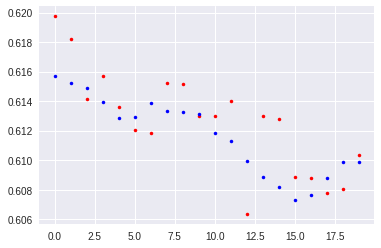

Epoch:  17
Loss:  4.9991561170481885e-05


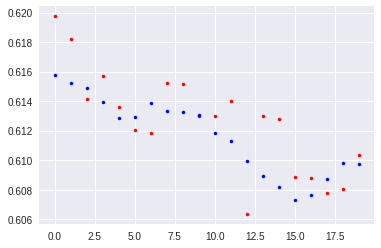

Epoch:  18
Loss:  4.952275644732901e-05


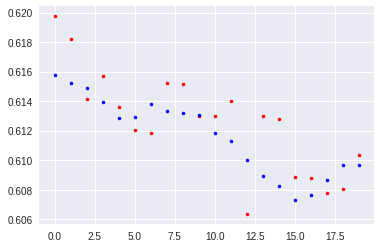

Epoch:  19
Loss:  4.909400462583675e-05


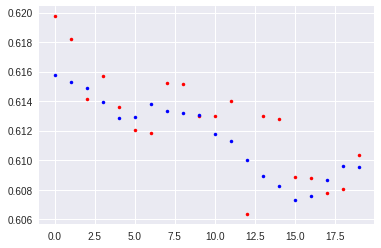

Epoch:  20
Loss:  4.870069271948802e-05


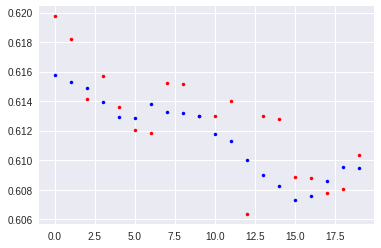

Epoch:  21
Loss:  4.8337493407372964e-05


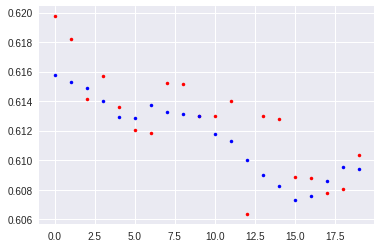

Epoch:  22
Loss:  4.799859762340943e-05


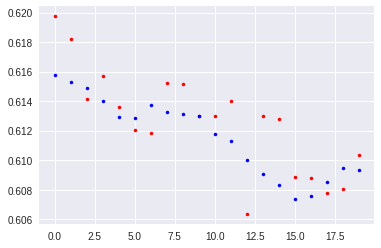

Epoch:  23
Loss:  4.7683369388382035e-05


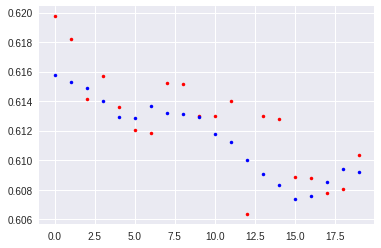

Epoch:  24
Loss:  4.7387371862300195e-05


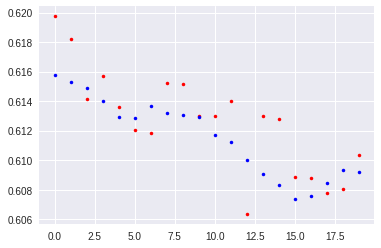

Epoch:  25
Loss:  4.710884768217587e-05


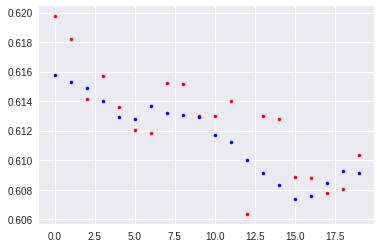

Epoch:  26
Loss:  4.684733109187823e-05


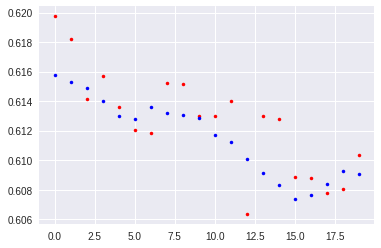

Epoch:  27
Loss:  4.66044528807692e-05


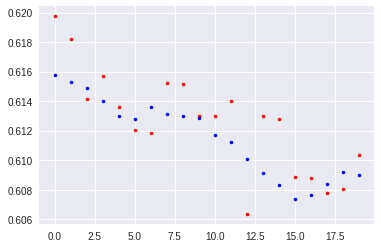

Epoch:  28
Loss:  4.6377074219717476e-05


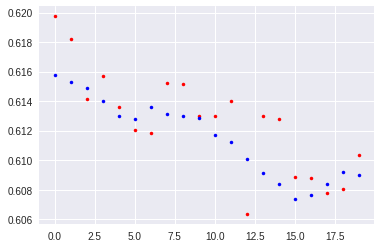

Epoch:  29
Loss:  4.616321548026031e-05


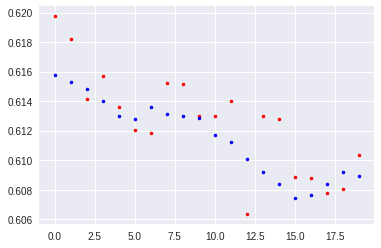

Epoch:  30
Loss:  4.596091495528394e-05


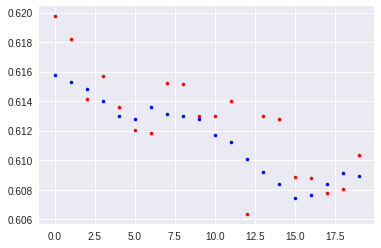

Epoch:  31
Loss:  4.576846367682689e-05


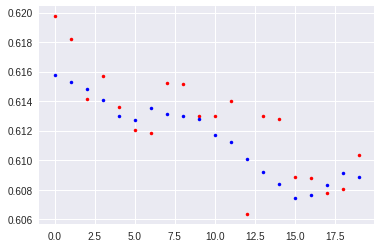

Epoch:  32
Loss:  4.5586306032632965e-05


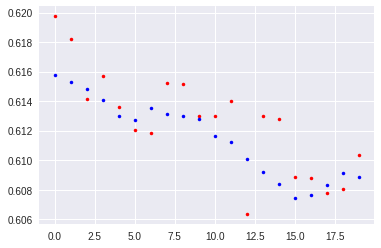

Epoch:  33
Loss:  4.541260593325684e-05


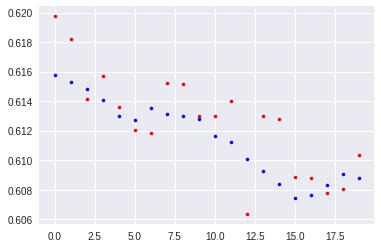

Epoch:  34
Loss:  4.524807563201003e-05


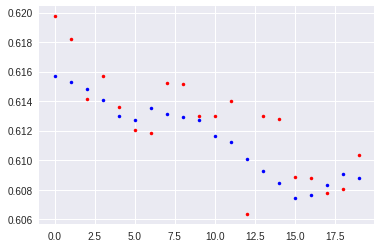

Epoch:  35
Loss:  4.509258321207721e-05


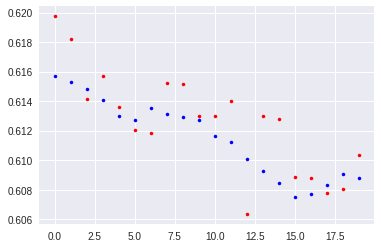

Epoch:  36
Loss:  4.4945320403057334e-05


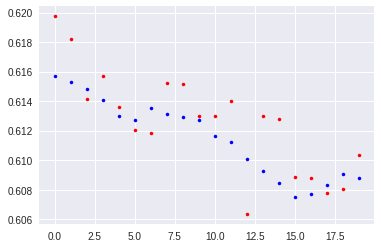

Epoch:  37
Loss:  4.480519108769945e-05


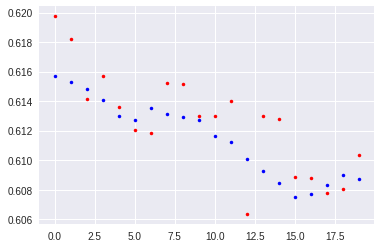

Epoch:  38
Loss:  4.467171023344524e-05


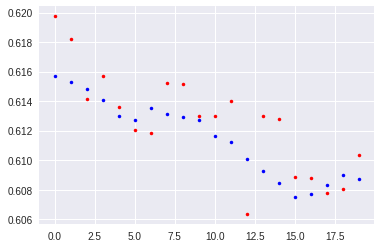

Epoch:  39
Loss:  4.454364927590496e-05


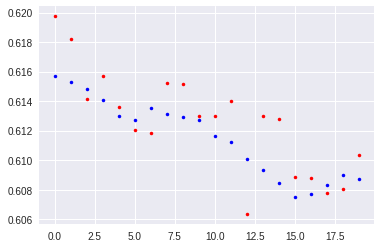

Epoch:  40
Loss:  4.4421121617017056e-05


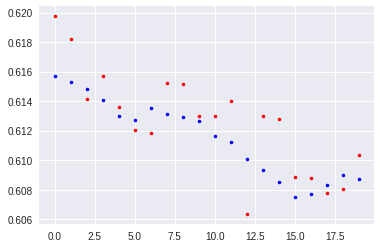

Epoch:  41
Loss:  4.430375335998433e-05


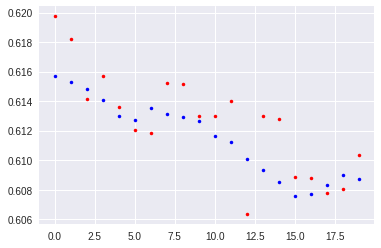

Epoch:  42
Loss:  4.419249338692747e-05


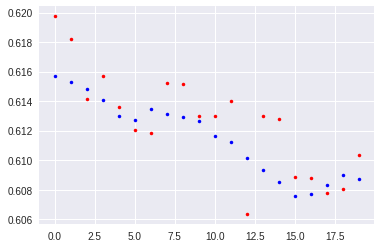

Epoch:  43
Loss:  4.4085782951184615e-05


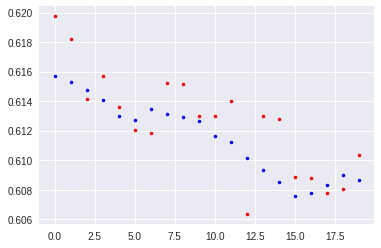

Epoch:  44
Loss:  4.398250725754651e-05


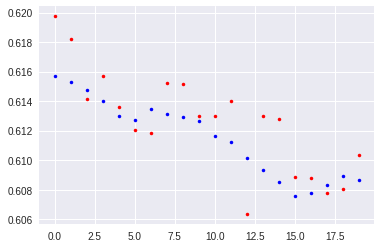

Epoch:  45
Loss:  4.388426844714009e-05


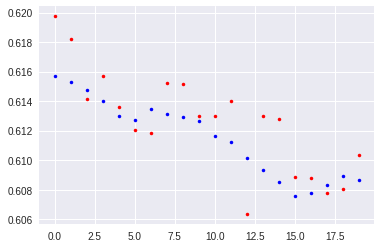

Epoch:  46
Loss:  4.379014047578986e-05


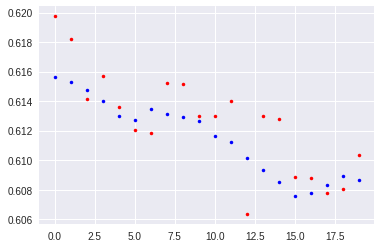

Epoch:  47
Loss:  4.369939521018336e-05


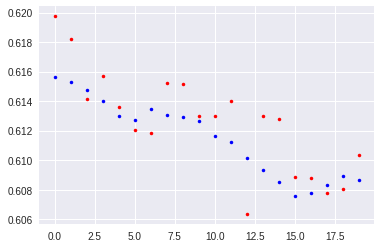

Epoch:  48
Loss:  4.3609411364698465e-05


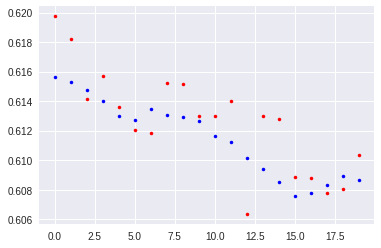

Epoch:  49
Loss:  4.352080404298474e-05


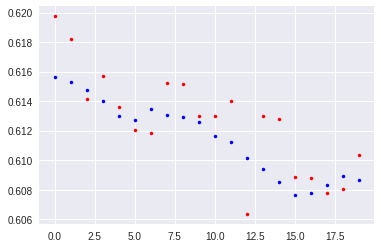

Epoch:  50
Loss:  4.343461268385479e-05


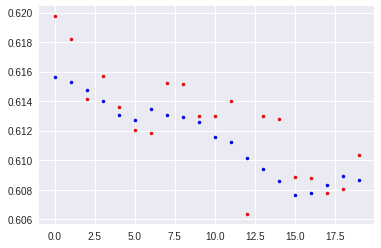

In [0]:
n_steps = 50
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.001, momentum=0.9)
rnn1, hidden =  train2(rnn1, n_steps, hidden)

entered train func() !!
Epoch:  1
Loss:  4.3354837716145474e-05


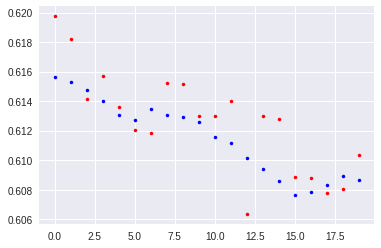

Epoch:  2
Loss:  4.3269080368871784e-05


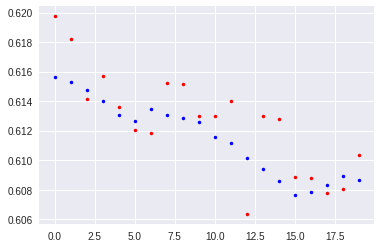

Epoch:  3
Loss:  4.319025883888768e-05


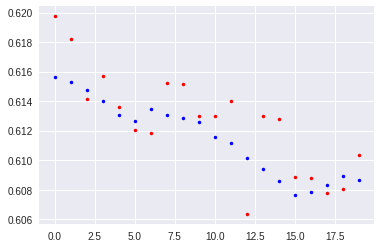

Epoch:  4
Loss:  4.311323857680433e-05


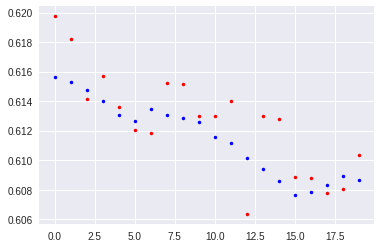

Epoch:  5
Loss:  4.3038836347048396e-05


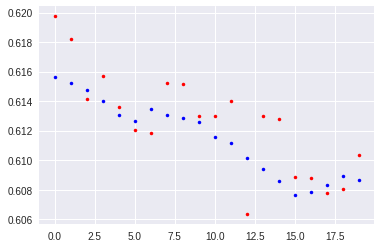

Epoch:  6
Loss:  4.296786666461068e-05


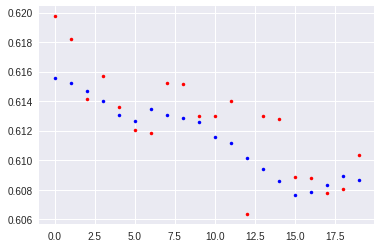

Epoch:  7
Loss:  4.2899893247161625e-05


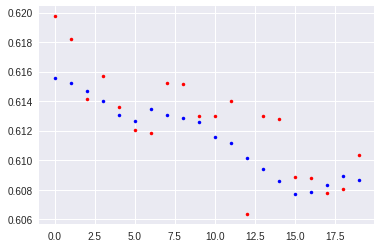

Epoch:  8
Loss:  4.2833619040371225e-05


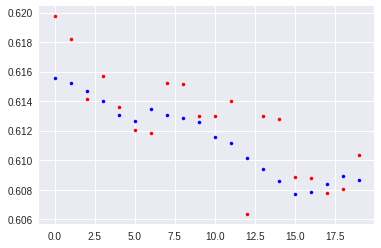

Epoch:  9
Loss:  4.276949169128869e-05


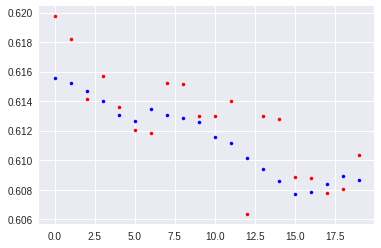

Epoch:  10
Loss:  4.270768338897329e-05


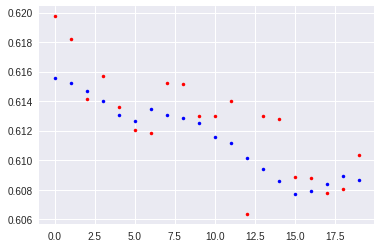

Epoch:  11
Loss:  4.264801496995667e-05


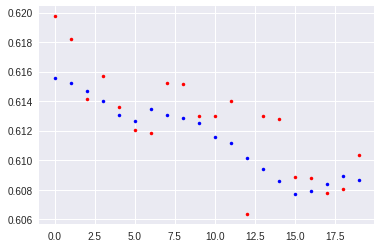

Epoch:  12
Loss:  4.258922486143073e-05


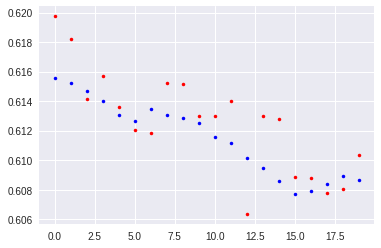

Epoch:  13
Loss:  4.253191220202788e-05


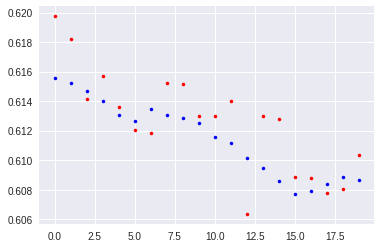

Epoch:  14
Loss:  4.247568724688404e-05


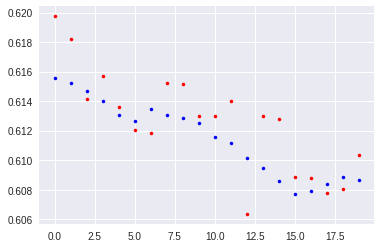

Epoch:  15
Loss:  4.242099276295887e-05


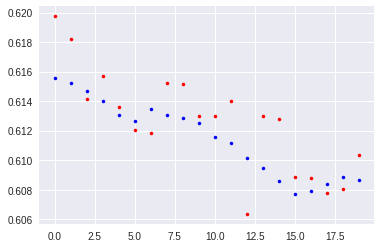

Epoch:  16
Loss:  4.236816880471263e-05


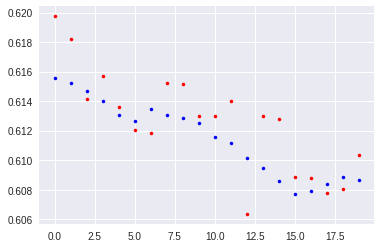

Epoch:  17
Loss:  4.2316465065898504e-05


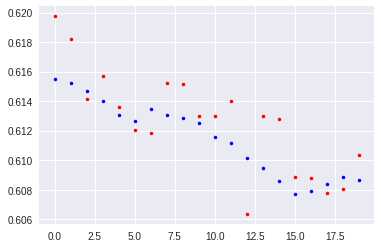

Epoch:  18
Loss:  4.226590928265705e-05


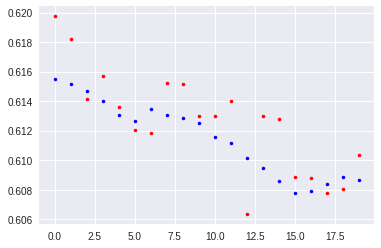

Epoch:  19
Loss:  4.221698743824955e-05


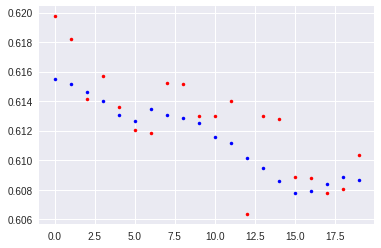

Epoch:  20
Loss:  4.2168970498645166e-05


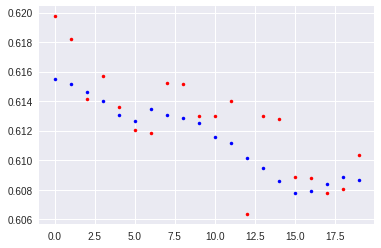

Epoch:  21
Loss:  4.212205831990238e-05


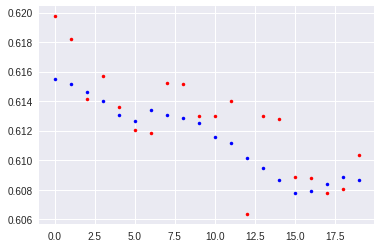

Epoch:  22
Loss:  4.207521894494933e-05


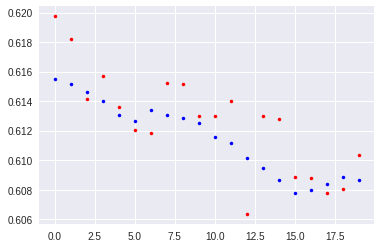

Epoch:  23
Loss:  4.202902188396173e-05


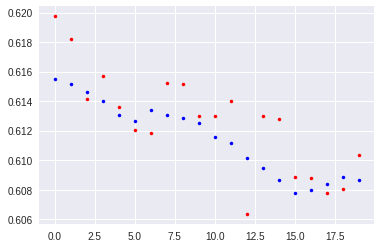

Epoch:  24
Loss:  4.1983939300741565e-05


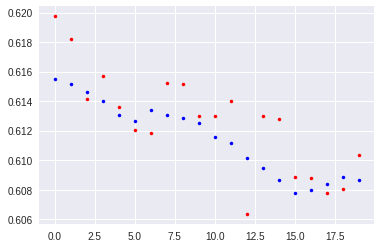

Epoch:  25
Loss:  4.193999041535229e-05


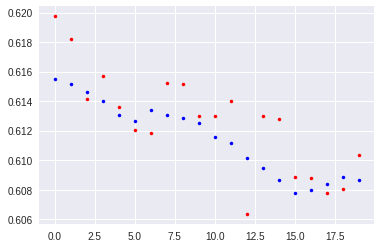

Epoch:  26
Loss:  4.1896843088397164e-05


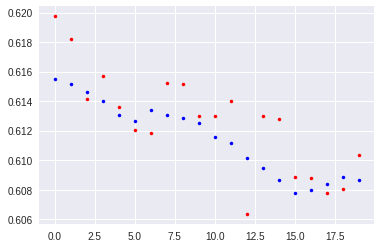

Epoch:  27
Loss:  4.1853861697651486e-05


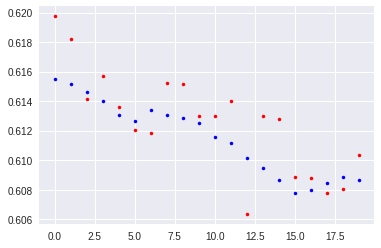

Epoch:  28
Loss:  4.181149033828971e-05


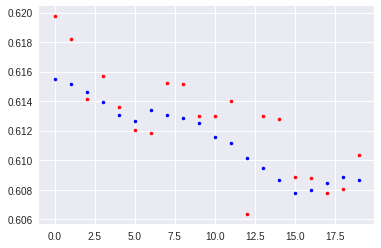

Epoch:  29
Loss:  4.1769717681730043e-05


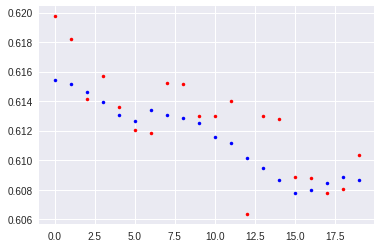

Epoch:  30
Loss:  4.172841531867085e-05


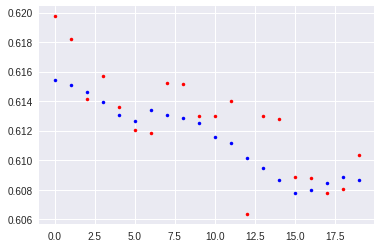

Epoch:  31
Loss:  4.168644255179688e-05


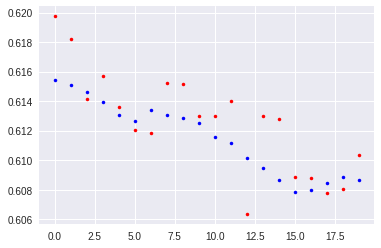

Epoch:  32
Loss:  4.164501390224181e-05


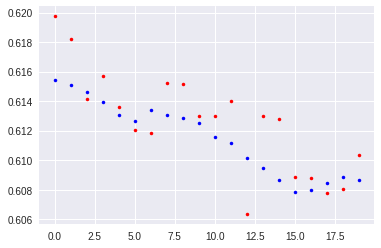

Epoch:  33
Loss:  4.1604095846640856e-05


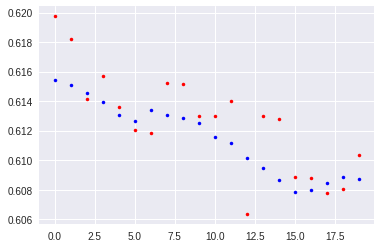

Epoch:  34
Loss:  4.156375548705512e-05


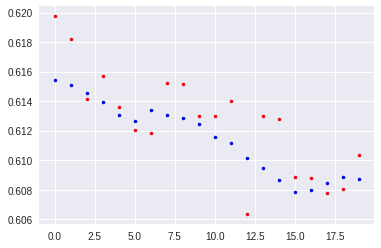

Epoch:  35
Loss:  4.152217091493273e-05


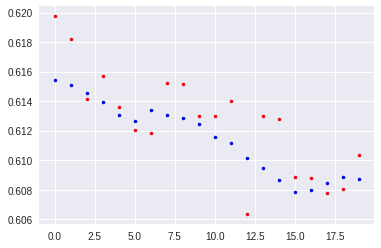

Epoch:  36
Loss:  4.148043182599754e-05


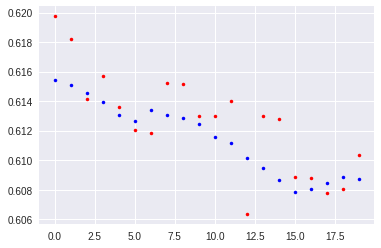

Epoch:  37
Loss:  4.14351040770473e-05


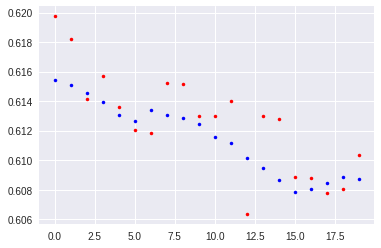

Epoch:  38
Loss:  4.1391435795922546e-05


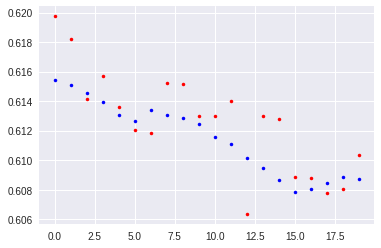

Epoch:  39
Loss:  4.1349203917625515e-05


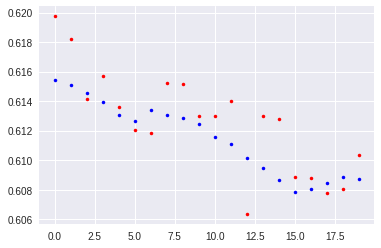

Epoch:  40
Loss:  4.130886755148816e-05


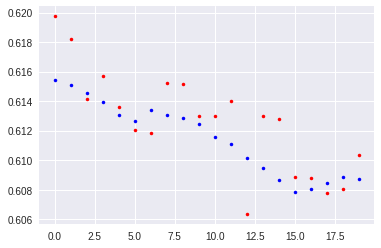

Epoch:  41
Loss:  4.1269918319887344e-05


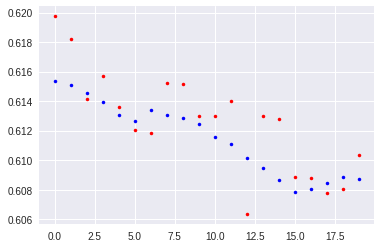

Epoch:  42
Loss:  4.1232436362465294e-05


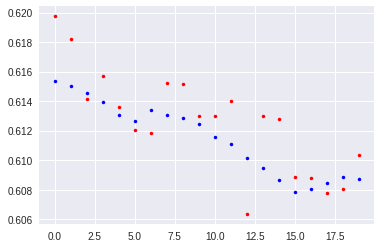

Epoch:  43
Loss:  4.119599061373732e-05


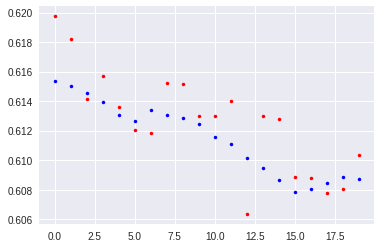

Epoch:  44
Loss:  4.116067234898615e-05


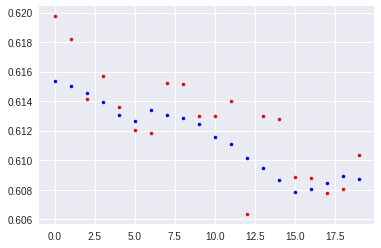

Epoch:  45
Loss:  4.1126511865385275e-05


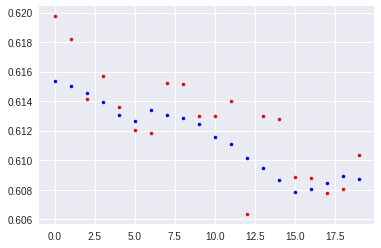

Epoch:  46
Loss:  4.1093248276708174e-05


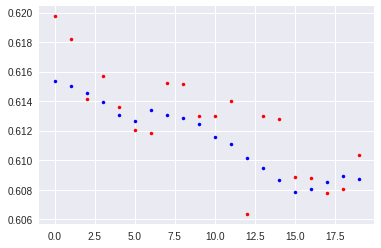

Epoch:  47
Loss:  4.106063726013173e-05


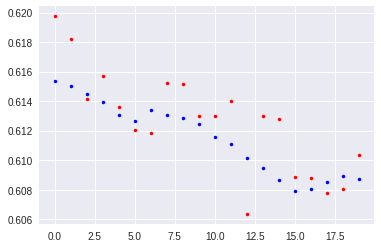

Epoch:  48
Loss:  4.1029126735647594e-05


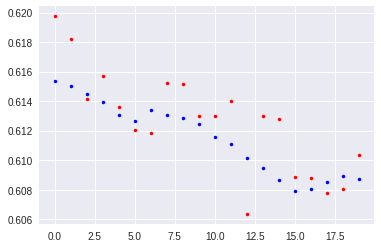

Epoch:  49
Loss:  4.09985897482551e-05


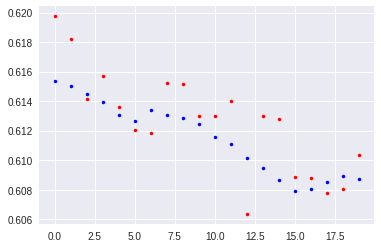

Epoch:  50
Loss:  4.0968703084412404e-05


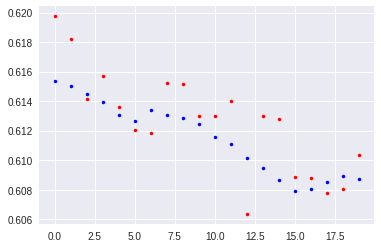

In [0]:
n_steps = 50
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.001, momentum=0.9)
rnn1, hidden =  train2(rnn1, n_steps, hidden)

entered train func() !!
Epoch:  1
Loss:  4.4001191547475636e-05


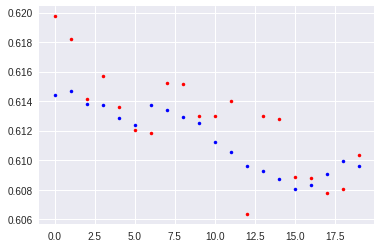

Epoch:  2
Loss:  4.3967805833746114e-05


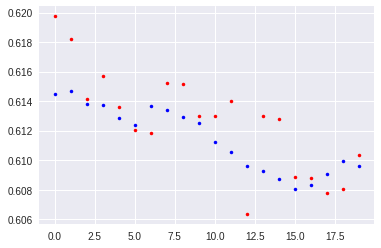

Epoch:  3
Loss:  4.3936779830469216e-05


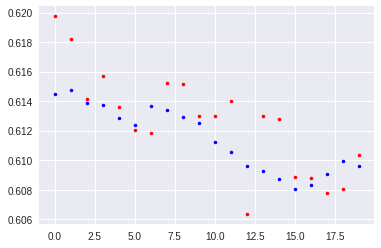

Epoch:  4
Loss:  4.390584559021664e-05


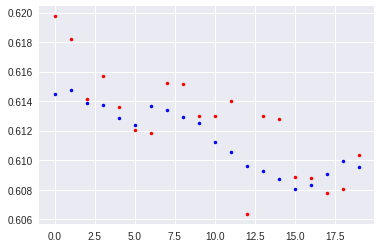

Epoch:  5
Loss:  4.387531514505363e-05


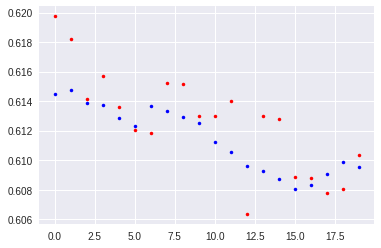

Epoch:  6
Loss:  4.384519988373337e-05


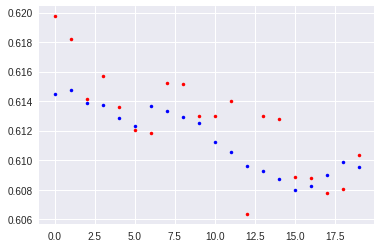

Epoch:  7
Loss:  4.3815466246762423e-05


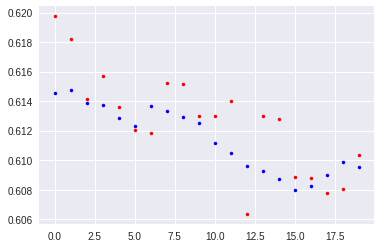

Epoch:  8
Loss:  4.378614072293427e-05


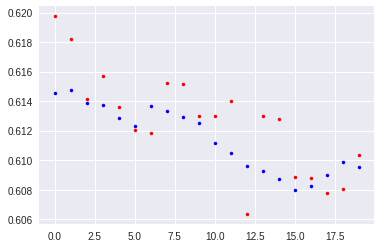

Epoch:  9
Loss:  4.375716443853544e-05


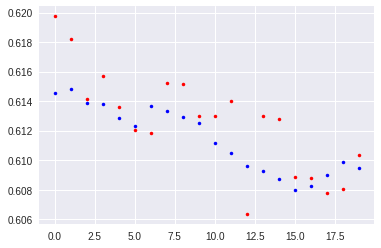

Epoch:  10
Loss:  4.3728702232962906e-05


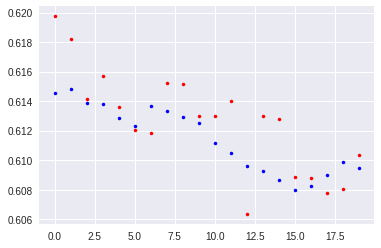

Epoch:  11
Loss:  4.370066071266384e-05


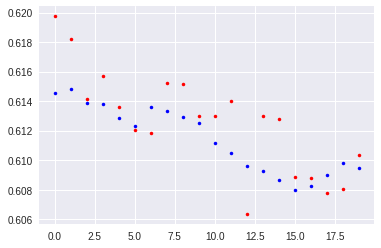

Epoch:  12
Loss:  4.3672970876107195e-05


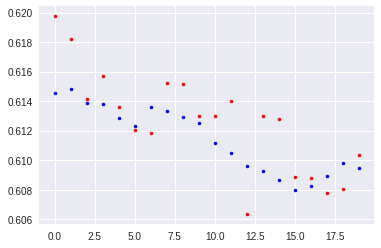

Epoch:  13
Loss:  4.3645768720905256e-05


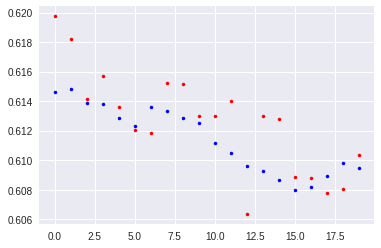

Epoch:  14
Loss:  4.3618964671518896e-05


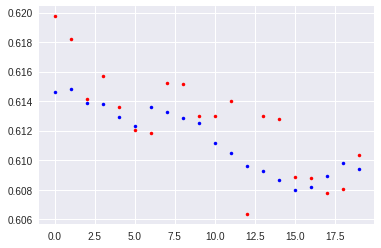

Epoch:  15
Loss:  4.359252955440474e-05


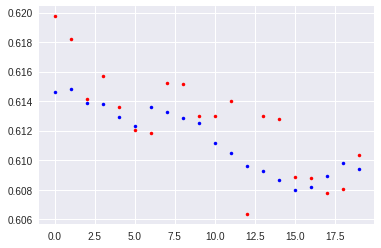

Epoch:  16
Loss:  4.3566620477102426e-05


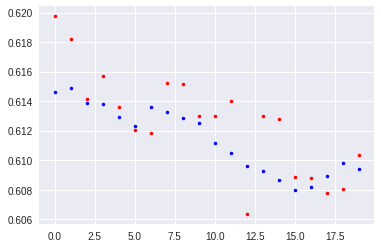

Epoch:  17
Loss:  4.3541088603720866e-05


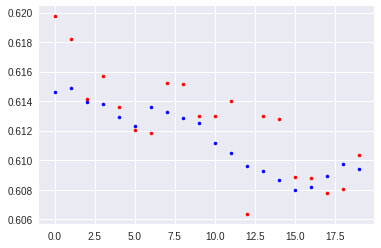

Epoch:  18
Loss:  4.3515839841319304e-05


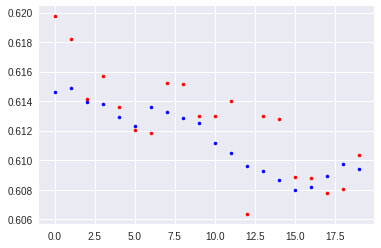

Epoch:  19
Loss:  4.349092681136985e-05


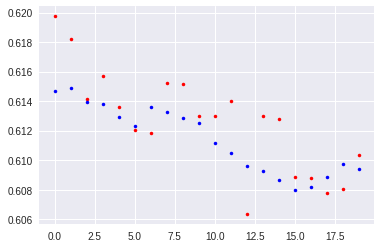

Epoch:  20
Loss:  4.346638163790831e-05


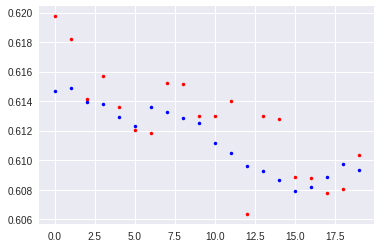

Epoch:  21
Loss:  4.344232017208142e-05


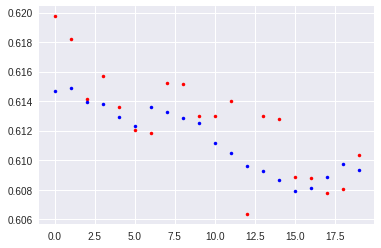

Epoch:  22
Loss:  4.3418573025230256e-05


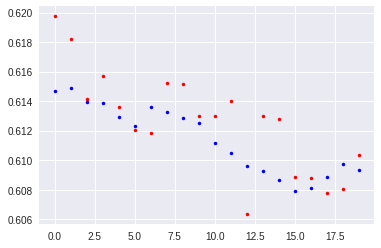

Epoch:  23
Loss:  4.339515515379311e-05


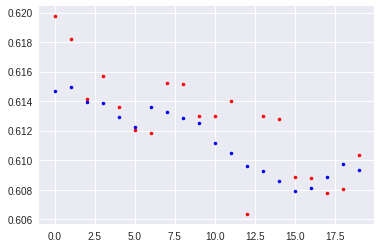

Epoch:  24
Loss:  4.337209369375428e-05


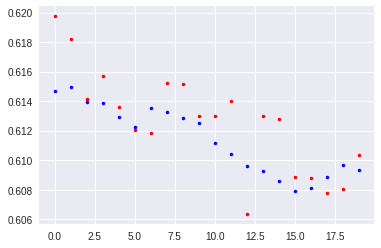

Epoch:  25
Loss:  4.3349253376362075e-05


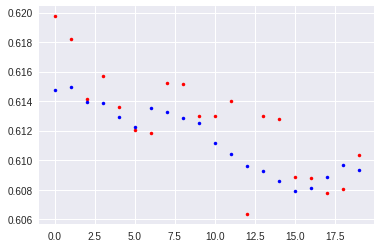

Epoch:  26
Loss:  4.3326703739951884e-05


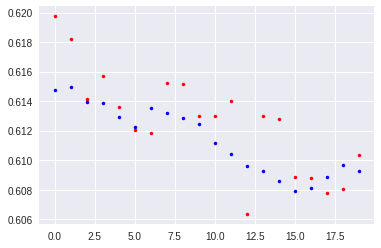

Epoch:  27
Loss:  4.330439763227165e-05


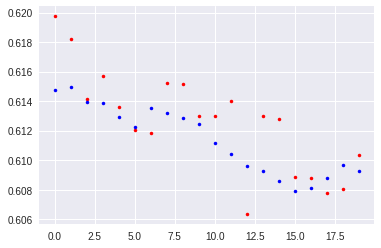

Epoch:  28
Loss:  4.3282412950893576e-05


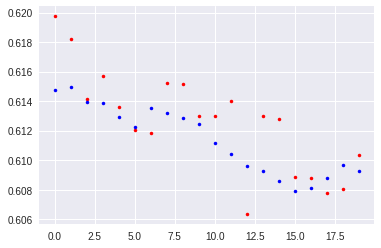

Epoch:  29
Loss:  4.32606015518841e-05


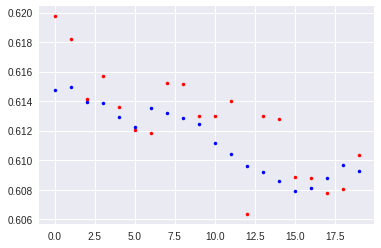

Epoch:  30
Loss:  4.323903032221016e-05


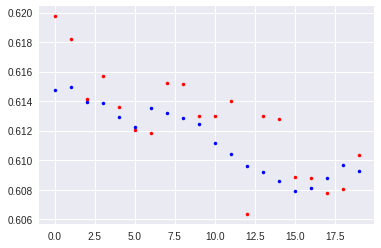

Epoch:  31
Loss:  4.321785611165239e-05


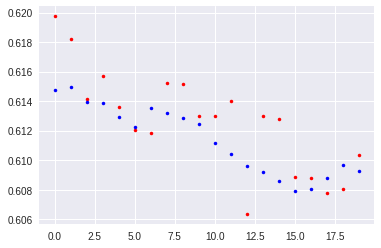

Epoch:  32
Loss:  4.3196789485571005e-05


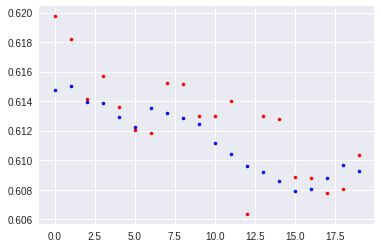

Epoch:  33
Loss:  4.3175899246259297e-05


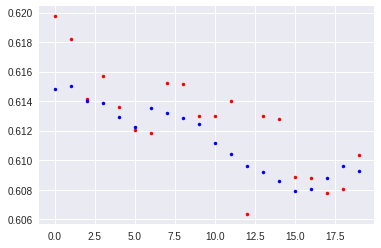

Epoch:  34
Loss:  4.315538126135163e-05


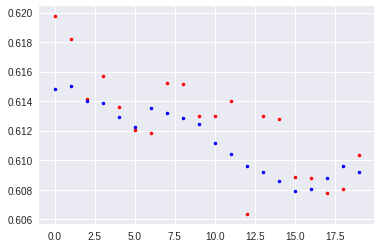

Epoch:  35
Loss:  4.313510865492662e-05


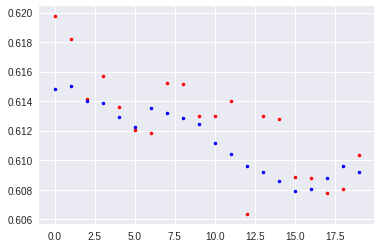

Epoch:  36
Loss:  4.311504144158478e-05


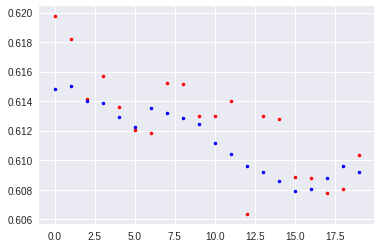

Epoch:  37
Loss:  4.3095293743828144e-05


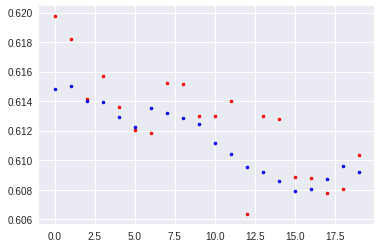

Epoch:  38
Loss:  4.3075815268432425e-05


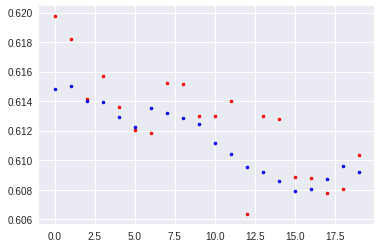

Epoch:  39
Loss:  4.3056528967867774e-05


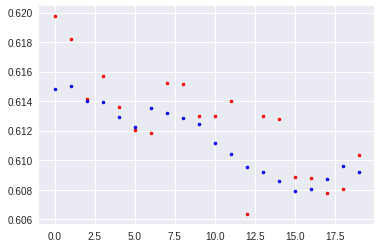

Epoch:  40
Loss:  4.303739950875915e-05


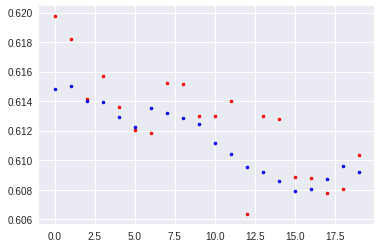

Epoch:  41
Loss:  4.30185113480092e-05


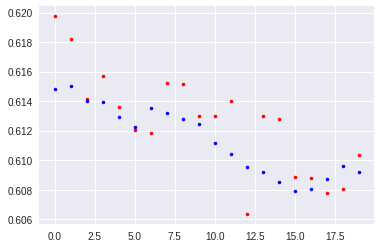

Epoch:  42
Loss:  4.29998749379205e-05


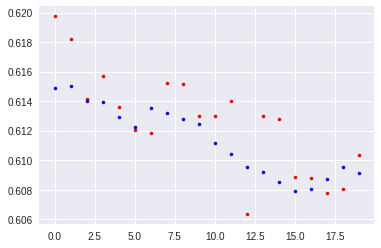

Epoch:  43
Loss:  4.298140827789725e-05


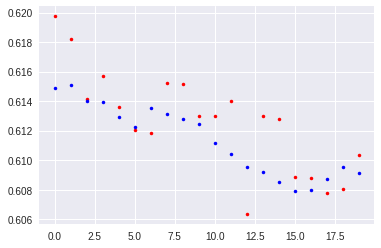

Epoch:  44
Loss:  4.296312142239342e-05


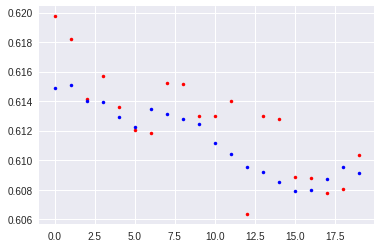

Epoch:  45
Loss:  4.2945034388598634e-05


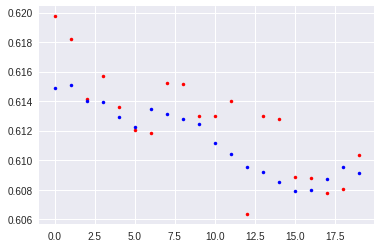

Epoch:  46
Loss:  4.292707133744499e-05


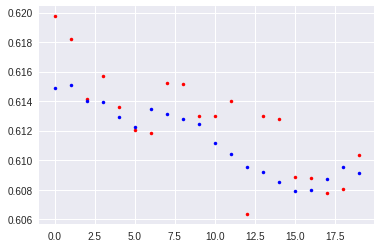

Epoch:  47
Loss:  4.2909290672254236e-05


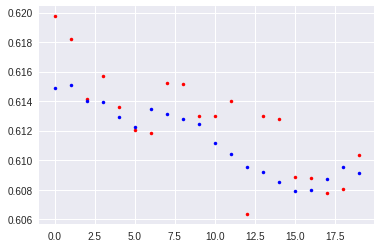

Epoch:  48
Loss:  4.289167006388787e-05


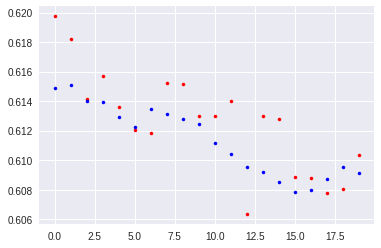

Epoch:  49
Loss:  4.2874281269851665e-05


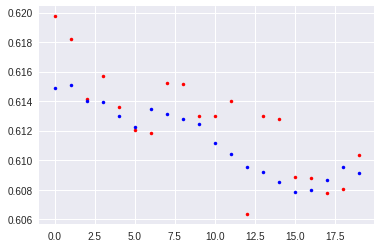

Epoch:  50
Loss:  4.285705673794659e-05


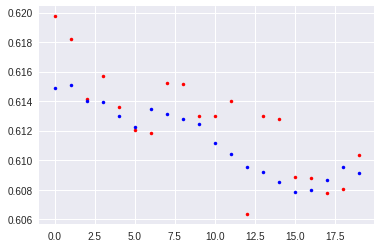

In [0]:
n_steps = 50
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.0001, momentum=0.9)
rnn1, hidden =  train2(rnn1, n_steps, hidden)

entered train func() !!
Epoch:  1
Loss:  4.4085478803769896e-05


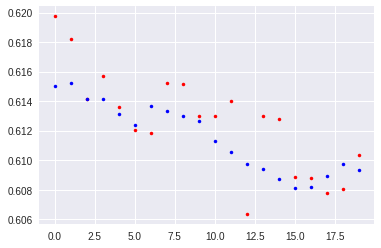

Epoch:  2
Loss:  4.369725996473968e-05


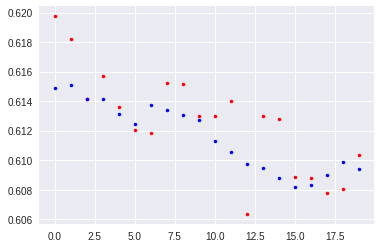

Epoch:  3
Loss:  4.358691040469252e-05


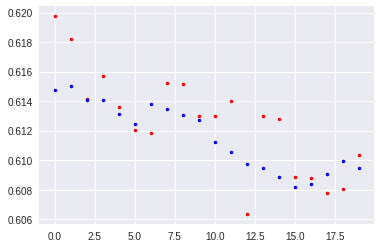

Epoch:  4
Loss:  4.3545399990037115e-05


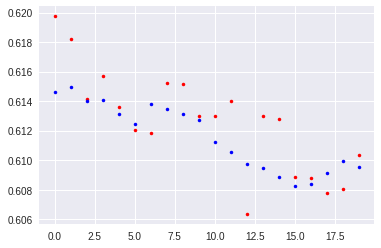

Epoch:  5
Loss:  4.352692159656792e-05


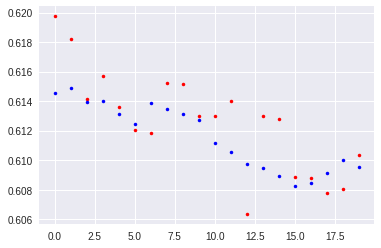

Epoch:  6
Loss:  4.351728251327734e-05


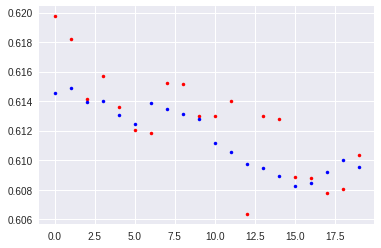

Epoch:  7
Loss:  4.351130724159254e-05


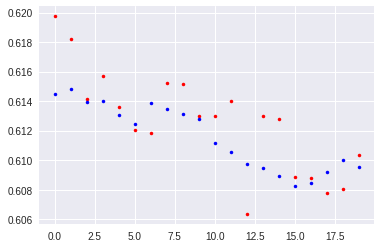

Epoch:  8
Loss:  4.3506913303245836e-05


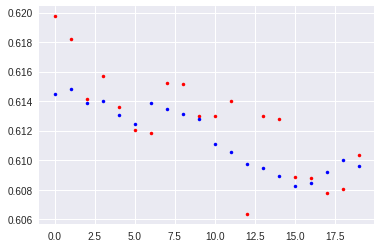

Epoch:  9
Loss:  4.3503172950178884e-05


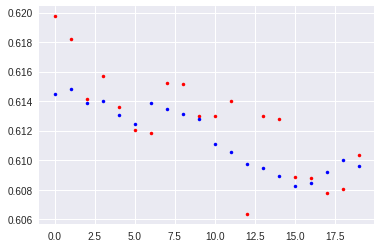

Epoch:  10
Loss:  4.3499742929949824e-05


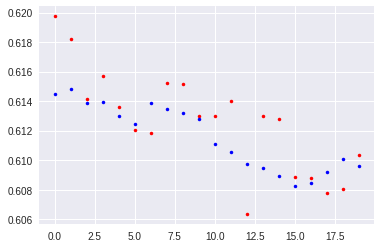

Epoch:  11
Loss:  4.3496484168192604e-05


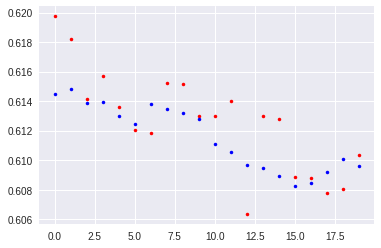

Epoch:  12
Loss:  4.3493295193633574e-05


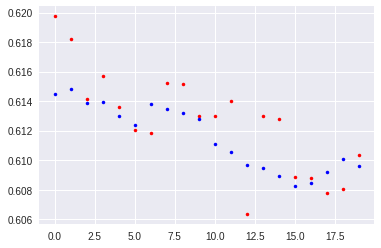

Epoch:  13
Loss:  4.349011648577406e-05


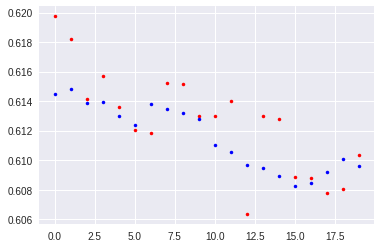

Epoch:  14
Loss:  4.3486942564008726e-05


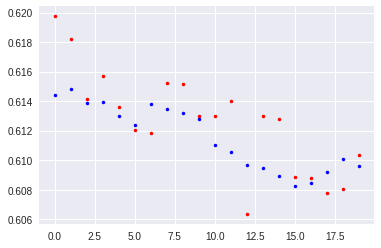

Epoch:  15
Loss:  4.348378184687925e-05


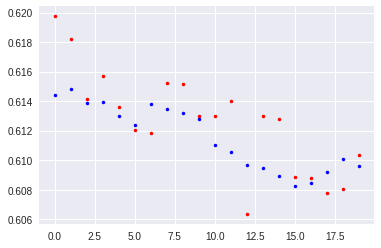

Epoch:  16
Loss:  4.348063374664717e-05


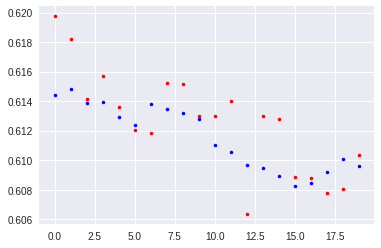

Epoch:  17
Loss:  4.347749667431492e-05


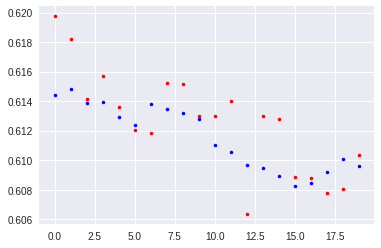

Epoch:  18
Loss:  4.347435004185256e-05


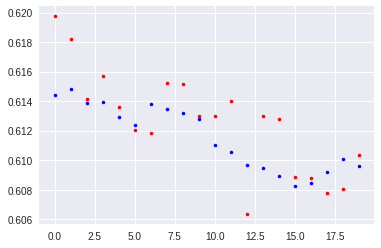

Epoch:  19
Loss:  4.3471231019380035e-05


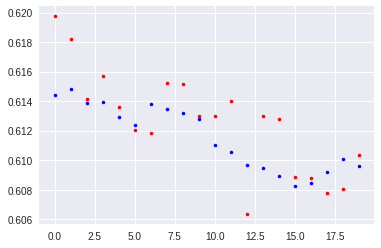

Epoch:  20
Loss:  4.346809658533467e-05


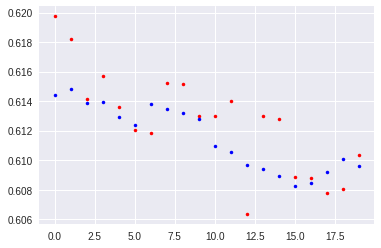

Epoch:  21
Loss:  4.346498368430651e-05


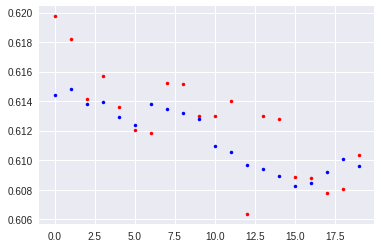

Epoch:  22
Loss:  4.346188668527548e-05


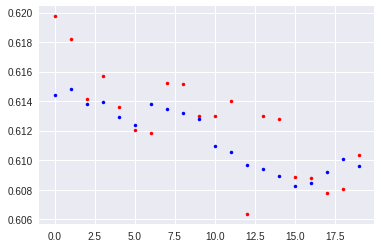

Epoch:  23
Loss:  4.3458766148920554e-05


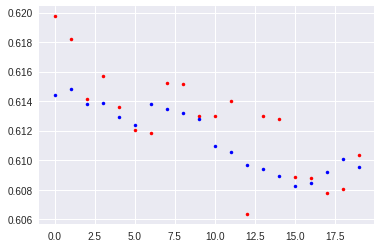

Epoch:  24
Loss:  4.345568586262905e-05


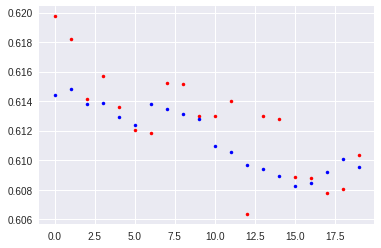

Epoch:  25
Loss:  4.3452603831615185e-05


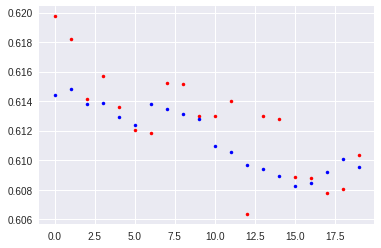

Epoch:  26
Loss:  4.3449511396762214e-05


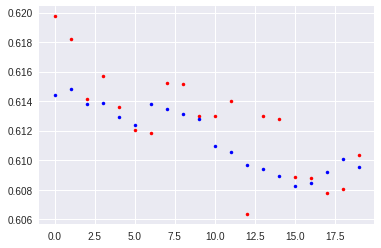

Epoch:  27
Loss:  4.344644768732441e-05


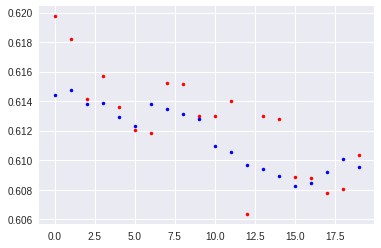

Epoch:  28
Loss:  4.3443388979167145e-05


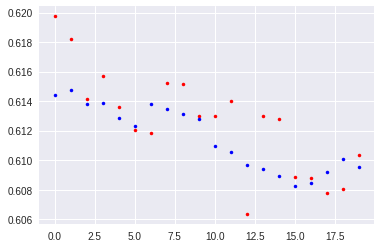

Epoch:  29
Loss:  4.3440344027633506e-05


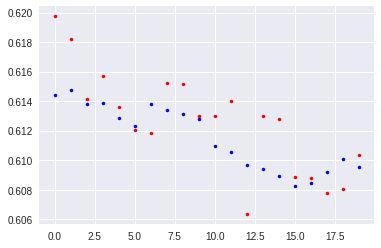

Epoch:  30
Loss:  4.343730101456554e-05


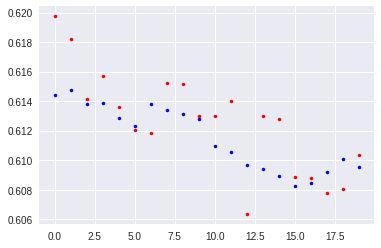

Epoch:  31
Loss:  4.343426171258185e-05


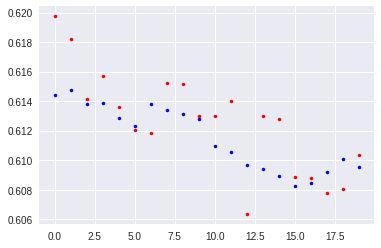

Epoch:  32
Loss:  4.3431243036333176e-05


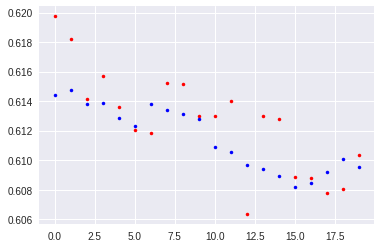

Epoch:  33
Loss:  4.3428209299952605e-05


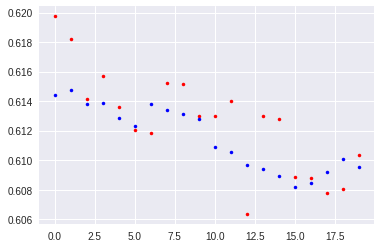

Epoch:  34
Loss:  4.3425197015113044e-05


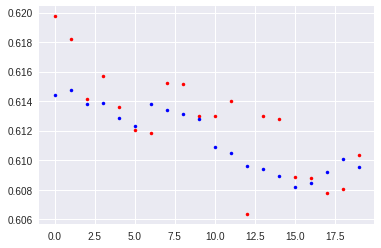

Epoch:  35
Loss:  4.342217596224527e-05


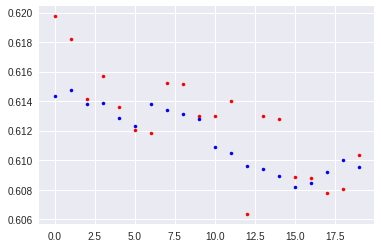

Epoch:  36
Loss:  4.3419178401234024e-05


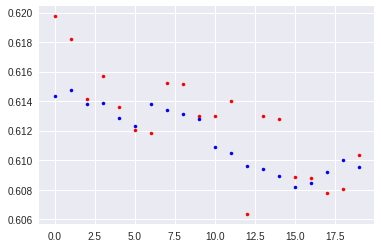

Epoch:  37
Loss:  4.3416184492232674e-05


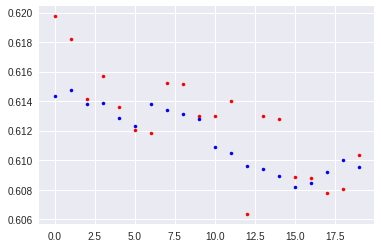

Epoch:  38
Loss:  4.341316955420857e-05


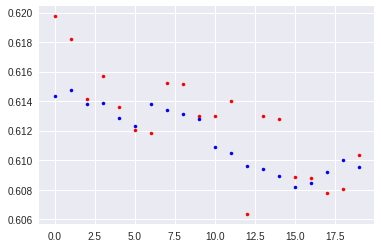

Epoch:  39
Loss:  4.3410180787351756e-05


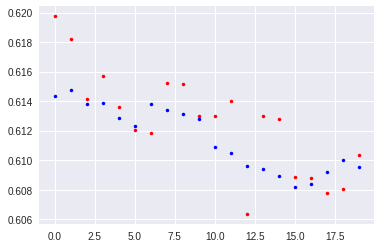

Epoch:  40
Loss:  4.340721032197392e-05


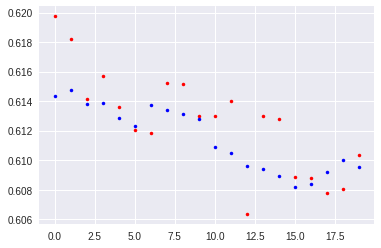

Epoch:  41
Loss:  4.340421584555246e-05


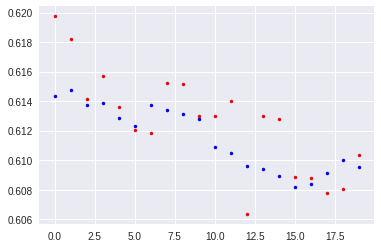

Epoch:  42
Loss:  4.3401245875429595e-05


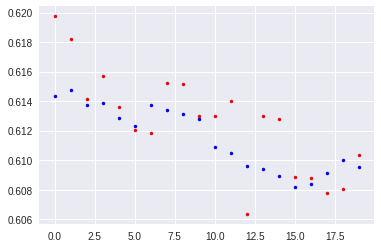

Epoch:  43
Loss:  4.3398287694167175e-05


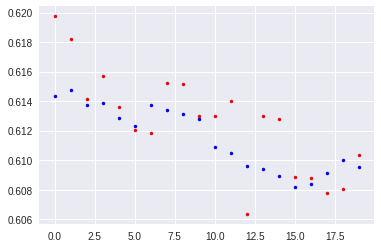

Epoch:  44
Loss:  4.339531733936021e-05


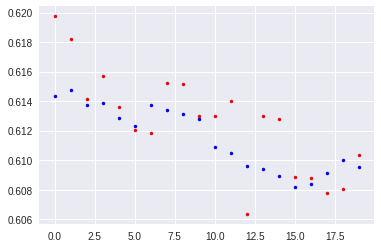

Epoch:  45
Loss:  4.33923452311836e-05


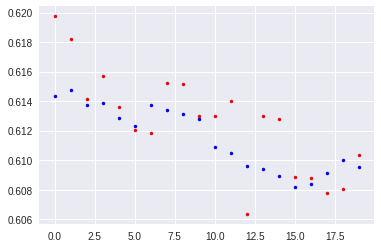

Epoch:  46
Loss:  4.3389389837774665e-05


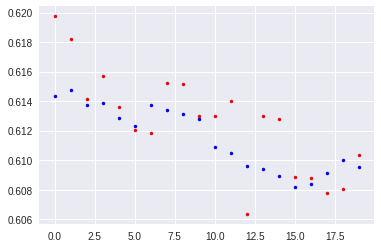

Epoch:  47
Loss:  4.338644115133602e-05


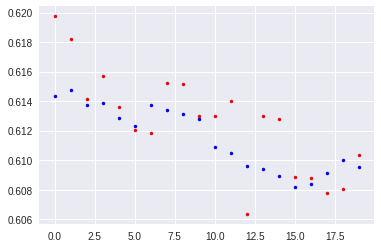

Epoch:  48
Loss:  4.33835053903312e-05


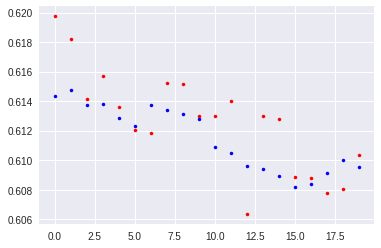

Epoch:  49
Loss:  4.338057539344818e-05


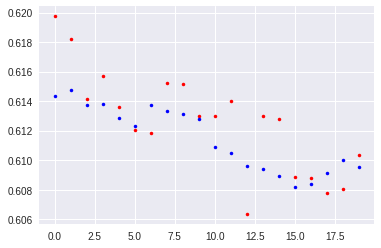

Epoch:  50
Loss:  4.3377657629036576e-05


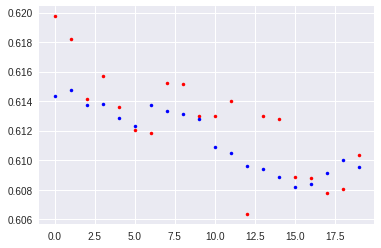

Epoch:  51
Loss:  4.3374752204495985e-05


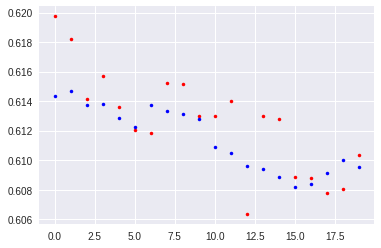

Epoch:  52
Loss:  4.337185565193535e-05


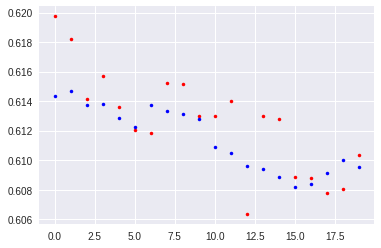

Epoch:  53
Loss:  4.336895725169625e-05


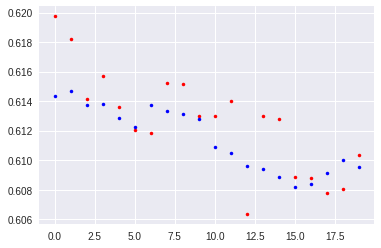

Epoch:  54
Loss:  4.336606733701985e-05


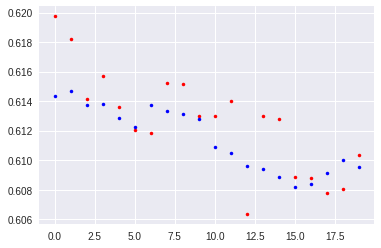

Epoch:  55
Loss:  4.3363179916078805e-05


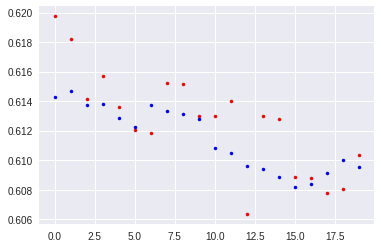

Epoch:  56
Loss:  4.3360305164103214e-05


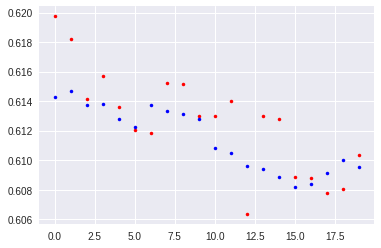

Epoch:  57
Loss:  4.335743545478236e-05


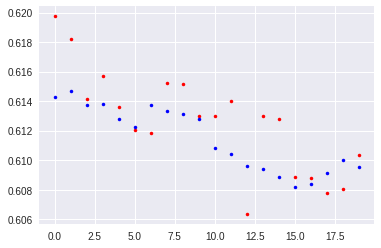

Epoch:  58
Loss:  4.335458085065512e-05


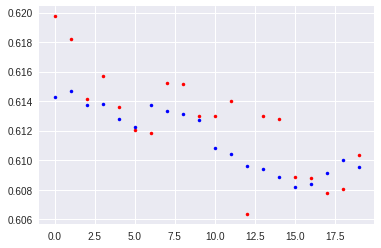

Epoch:  59
Loss:  4.3351731869416937e-05


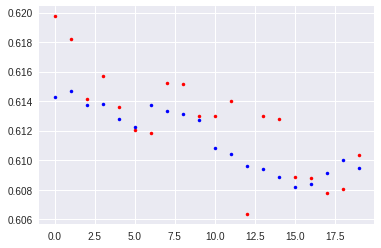

Epoch:  60
Loss:  4.334889252831002e-05


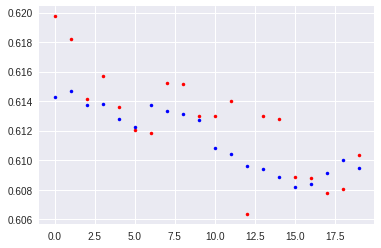

Epoch:  61
Loss:  4.334604118441007e-05


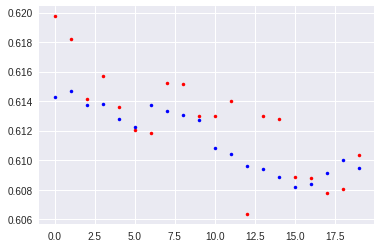

Epoch:  62
Loss:  4.334321512589359e-05


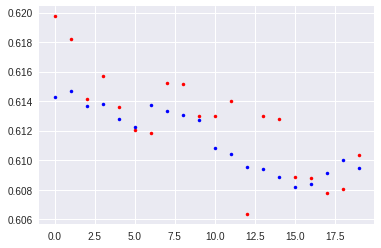

Epoch:  63
Loss:  4.334036723067262e-05


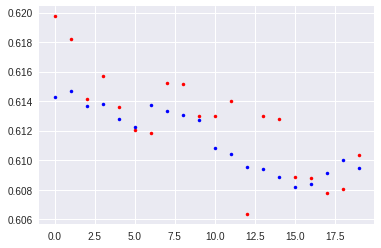

Epoch:  64
Loss:  4.333754745325251e-05


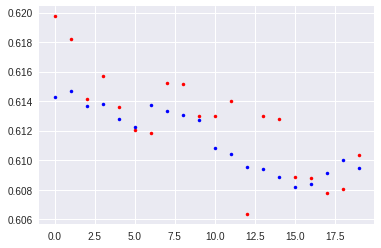

Epoch:  65
Loss:  4.333471869711663e-05


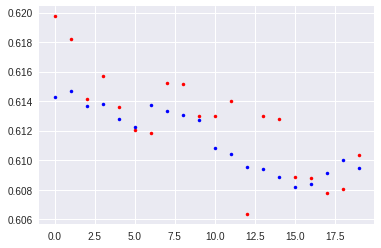

Epoch:  66
Loss:  4.33318865755111e-05


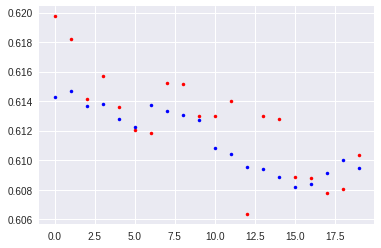

Epoch:  67
Loss:  4.3329086788610496e-05


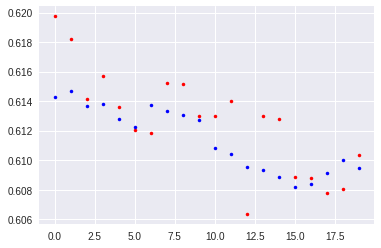

Epoch:  68
Loss:  4.332627471479194e-05


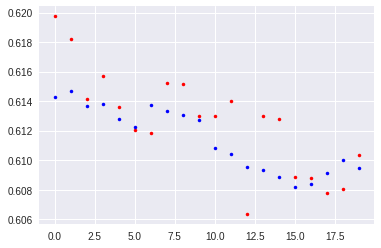

Epoch:  69
Loss:  4.332350468476657e-05


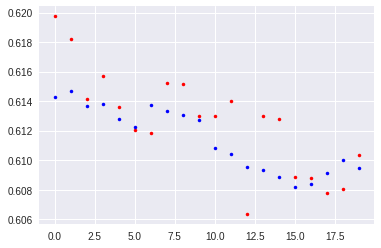

Epoch:  70
Loss:  4.332071441136713e-05


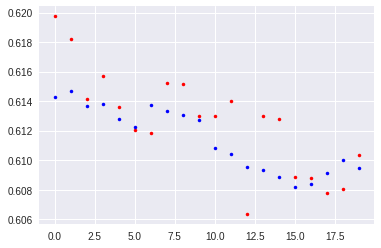

Epoch:  71
Loss:  4.331794211719261e-05


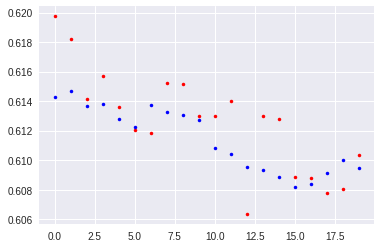

Epoch:  72
Loss:  4.33151603045203e-05


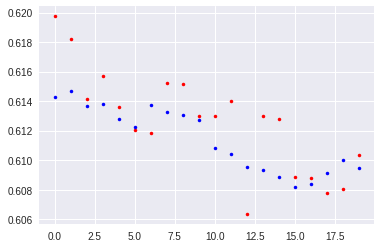

Epoch:  73
Loss:  4.3312390210847996e-05


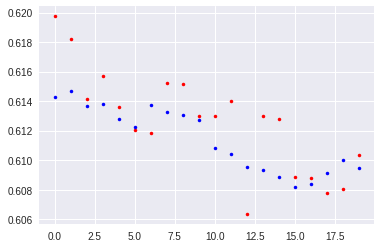

Epoch:  74
Loss:  4.33096164175781e-05


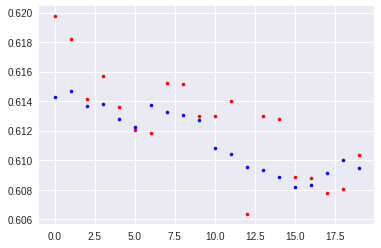

Epoch:  75
Loss:  4.330687339951587e-05


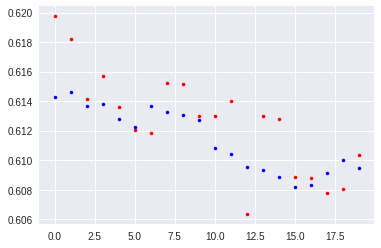

Epoch:  76
Loss:  4.3304121501287354e-05


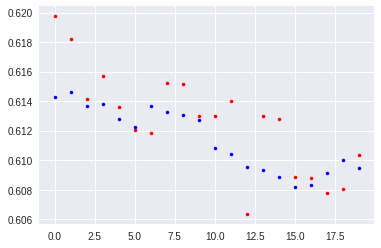

Epoch:  77
Loss:  4.330138654497893e-05


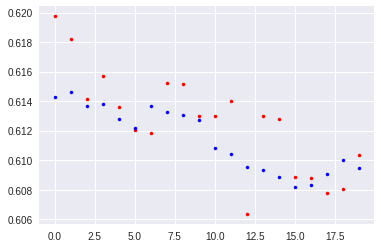

Epoch:  78
Loss:  4.329864257151214e-05


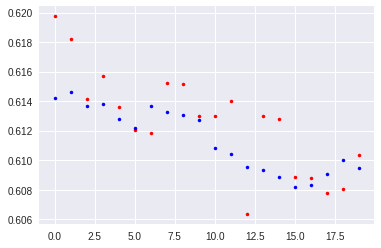

Epoch:  79
Loss:  4.329592596998607e-05


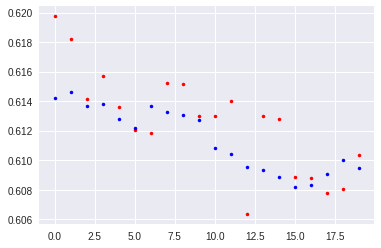

Epoch:  80
Loss:  4.3293202218948116e-05


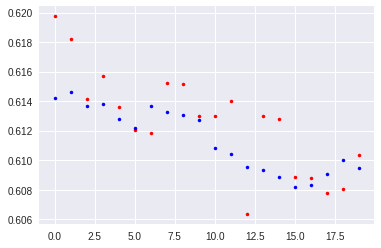

Epoch:  81
Loss:  4.329048569338536e-05


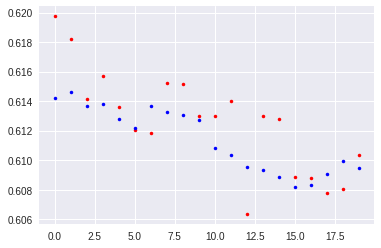

Epoch:  82
Loss:  4.328778757264487e-05


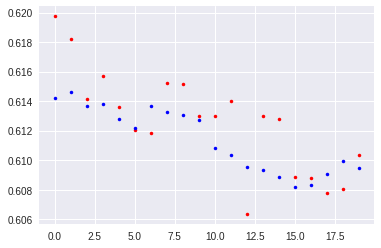

Epoch:  83
Loss:  4.328510729555691e-05


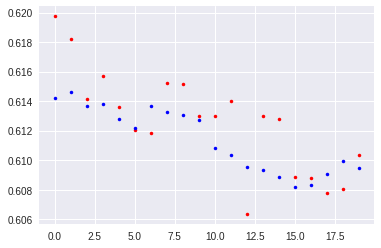

Epoch:  84
Loss:  4.32824230464544e-05


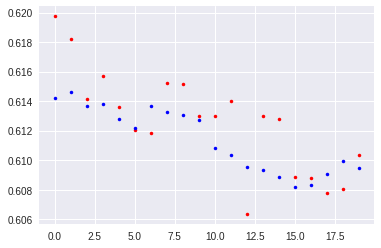

Epoch:  85
Loss:  4.3279738491452056e-05


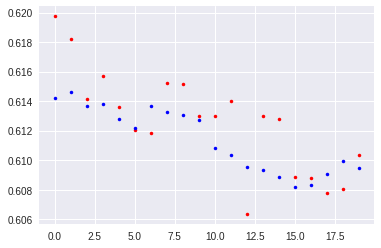

Epoch:  86
Loss:  4.3277070175266686e-05


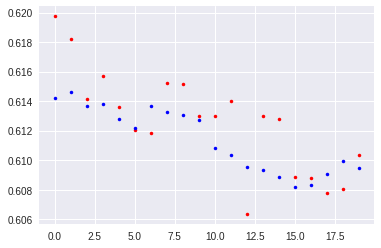

Epoch:  87
Loss:  4.3274407254707306e-05


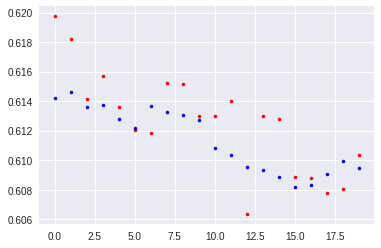

Epoch:  88
Loss:  4.327176178411876e-05


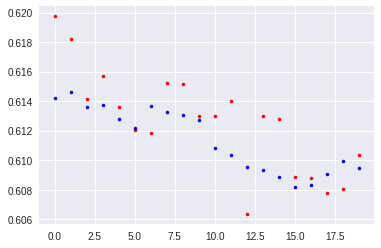

Epoch:  89
Loss:  4.3269122157155365e-05


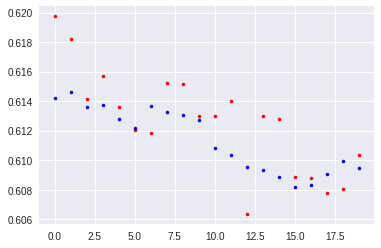

Epoch:  90
Loss:  4.326648269860188e-05


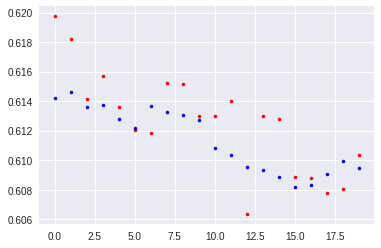

Epoch:  91
Loss:  4.326386017166183e-05


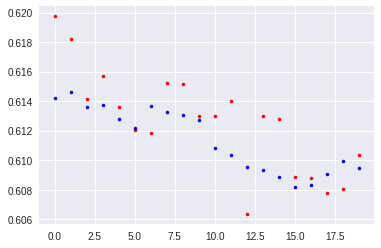

Epoch:  92
Loss:  4.326124674757857e-05


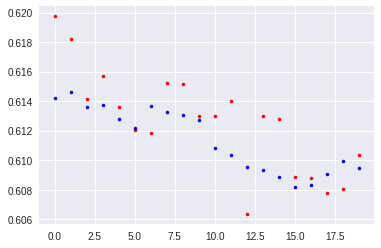

Epoch:  93
Loss:  4.3258637533024275e-05


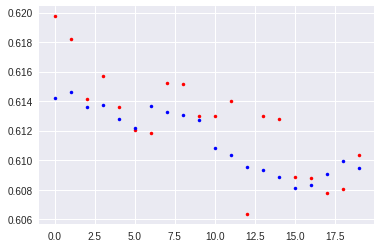

Epoch:  94
Loss:  4.325604782289804e-05


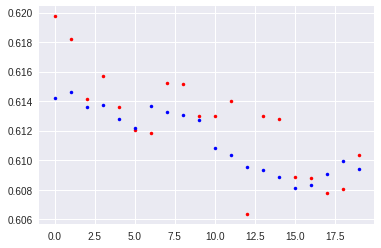

Epoch:  95
Loss:  4.32534520693189e-05


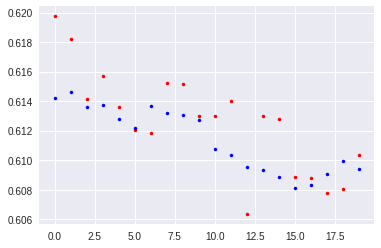

Epoch:  96
Loss:  4.325087994475431e-05


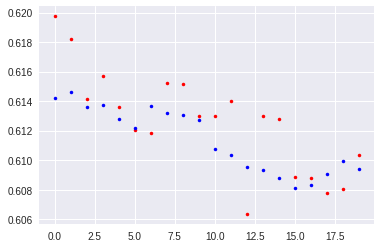

Epoch:  97
Loss:  4.3248314413620685e-05


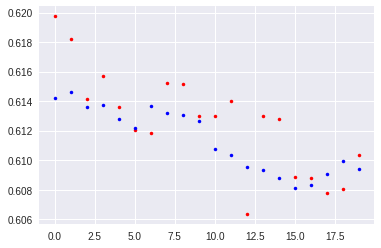

Epoch:  98
Loss:  4.3245753746462066e-05


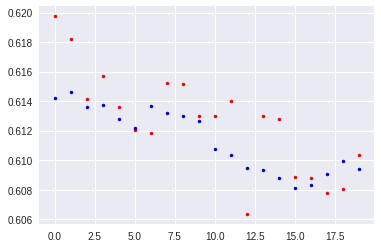

Epoch:  99
Loss:  4.324319920753289e-05


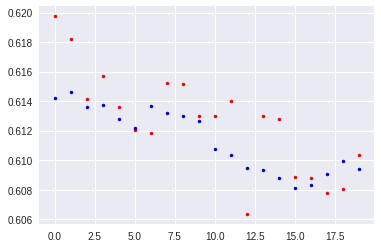

Epoch:  100
Loss:  4.324064138350397e-05


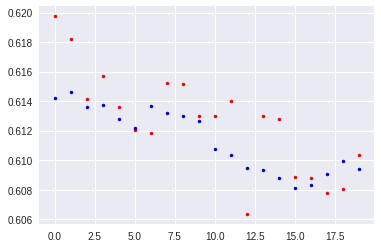

In [0]:
n_steps = 100
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.00001, momentum=0.9)
rnn1, hidden =  train2(rnn1, n_steps, hidden)

In [0]:
rnn1.cuda()

with torch.no_grad():
    p=0
    count = 0
    for i in range(int(len(data)-20)):
        x = data[i :  i+20].reshape((1,20)) 
        y = data[i+1 :  i+21].reshape(1,20)
        x_tensor = torch.Tensor(x).unsqueeze(0).cuda() 
        y_tensor = torch.Tensor(y).cuda()
        prediction, hidden = rnn1(x_tensor, hidden)
        pred = prediction.data.cpu().numpy().flatten()
        prediction = min_max_scaler.inverse_transform(pred.reshape(1, -1))
        y_true = min_max_scaler.inverse_transform(y)

        inp = min_max_scaler.inverse_transform(x[:,0].reshape(1, -1))
        pred = prediction[:,-1]
        true = y_true[:,-1]
        if inp < pred and inp < true: 
          p+=1
          count+=1
        elif inp>pred and inp>true: 
          p+=1
          count+=1
        else:
          p+=0
          count+=1
#         print(f'for-{inp}---pred:{pred}-actual:{true}')
#         plt.plot( x.reshape(100,1), 'r.') # input
#         plt.plot(pred, 'b.')
#         plt.show()
    print(f'acc={p/count}')

    
#     prediction = min_max_scaler.inverse_transform(pred)
    

acc=0.8743107362958158


In [0]:
acc=0.5893610120012974
acc=0.5951994810249757
acc=0.6016866688290626
acc=0.6062277002919234
acc=0.8060330846578009
acc=0.8177100227051574
acc=0.8681479078819332
acc=0.8713915017839766
acc=0.8743107362958158

0.2559629